In [39]:
import pandas as pd
import numpy as np
from typing import Callable, List, Tuple, Dict, Iterable, Any
from collections import defaultdict
from scipy.stats import pearsonr
import networkx as nx
import matplotlib.pyplot as plt
from pyvis.network import Network
from statsmodels.tsa.stattools import grangercausalitytests
from utils import time_consuming, any_in
from utils.preprocessing import standardize_df
from tqdm.notebook import tqdm
from scipy.signal import coherence
import seaborn as sns
import igraph as ig
import warnings
import math

df_norm = pd.DataFrame()

ig.config["plotting.backend"] = "matplotlib"
ig.config["plotting.layout"] = "fruchterman_reingold"
ig.config["plotting.palette"] = "rainbow"
warnings.simplefilter("ignore")

class Edge:
    def __init__(self, src: Any, dst: Any, rho: float):
        self.src = src
        self.dst = dst
        self.rho = rho
        
def plot_graph_pyvis(edges: List[Edge], at_rho: float,
                     name: str="pyvis", dataframe: pd.DataFrame=df_norm):
    """
    Plots graph with help of networkx
    :param dataframe: pd.DataFrame: dataframe on each
    :param name: str: Name of visualisation
    :param edges: List[Edge]: list of graph edges
    :param: at_rho: float: rho which should be used for filtering edges
    :return: None
    """
    net = Network(notebook=True)
    net.add_nodes(dataframe.columns)
    edges_list = list()
    n = 0
    for edge in tqdm(edges):
        if edge.rho < at_rho:
            continue
        edges_list.append([edge.src, edge.dst])
        n += 1
    print("There's %d edges" % len(edges_list))
    print("There is %d nodes in graph" % len(graph.keys()))
    #net.add_edges(edges_list)
    #net.show(f"../out/{name}.html")
    
    
# Generic method for building graph
def build_graph(rho: Callable,  n_eps: int = 1,
                exclude_columns: Tuple[str] = ('x', 'y', 'time_s',),
                use_lag: bool = True, dataframe=df_norm) -> Tuple[Dict[str, List[str]], List[Edge]]:
                
    """
    Builg graph with arbitary metrics
    :param dataframe: pd.DataFrame: a dataframe with neuron activity
    :param rho: Callable: metric which accepts two time series and returns float similarity value
    :param mu_min: float: minimal value of metric to state that one neuron activation depends on other
    :param n_eps: int: integer value of epsilon for shifting dataset, takes effect only if lag enabled
    :param exclude_columns: List[str] columns which should be ignored
    :param: use_lag: bool: Whether to lag time series
    :return: Tuple[Dict[str, List[str]], List[Edge]]: graph representation in from of mapping
                                   node name and list of node name it flows to and list of all
                                   edges graph.
    """
    df_neurons = dataframe#.drop(list(exclude_columns), axis=1)
    graph = defaultdict(lambda: list())
    rho_avg = 0.0
    n = 0
    rho_values = list()
    edges = list()
    for a_column in tqdm(df_neurons.columns):
        if a_column in exclude_columns:
            continue
        for b_column in df_neurons.columns:
            if a_column == b_column:
                continue
            if b_column in exclude_columns:
                continue
            n += 1
            a = df_neurons[a_column]
            b = df_neurons[b_column]
            if use_lag:
                a = a[:int(-n_eps)]
                b = b[int(n_eps):]
            result = rho(a, b)
            rho_values.append(result)
            rho_avg += result
            if not isinstance(result, float):
                raise TypeError(f"rho should return float, got {result}")
            graph[a_column].append(Edge(a_column, b_column, result))
            edges.append(Edge(a_column, b_column, result))
    #if not any_in([None, math.inf, -math.inf], rho_values):
        #plt.title("$\\rho$ distribution")
        #sns.distplot(rho_values)
        #plt.show()
    else:
        print("NaNs detected in rho values, would not build plots")
    return graph, edges

def get_slices(dataframe: pd.DataFrame, n: int) -> List[pd.DataFrame]:
    step = len(dataframe) // n
    #print(step)
    result = list()
    for i in range(0, len(dataframe), step):
        #print(dataframe)
        result.append(dataframe[int(i): int(i + step)].copy())
    return result

def coh(x, y, fs: int=1000, f_range: Tuple[int, int]=(1, 1000,)) -> float:
    f, c = coherence(x, y, fs)
    f_idx = np.logical_and(f >= f_range[0], f <= f_range[1])
    return float(np.mean(c[f_idx]))


In [40]:
import pickle
with open('data/coords1.pkl', 'rb') as f:
    data_new1 = pickle.load(f)
    
with open('data/coords2.pkl', 'rb') as f:
    data_new2 = pickle.load(f)
    
with open('data/coords3.pkl', 'rb') as f:
    data_new3 = pickle.load(f)

In [41]:
CoM1 = list(pd.DataFrame(data_new1)["CoM"])
CoM2 = list(pd.DataFrame(data_new2)["CoM"])
CoM3 = list(pd.DataFrame(data_new3)["CoM"])
CoM3 = list(np.delete(np.array(CoM3), np.argmax(np.array(CoM3).T[0]), 0))

In [42]:
CoM1 = [l.tolist() for l in CoM1]
CoM2 = [l.tolist() for l in CoM2]
CoM3 = [l.tolist() for l in CoM3]

In [43]:
CoM1 = list(np.array(CoM1) - np.mean(np.array(CoM1),axis=0))
CoM2 = list(np.array(CoM2) - np.mean(np.array(CoM2),axis=0))
CoM3 = list(np.array(CoM3) - np.mean(np.array(CoM3),axis=0))

In [55]:
np.max(np.array(CoM3))

275.02950438414257

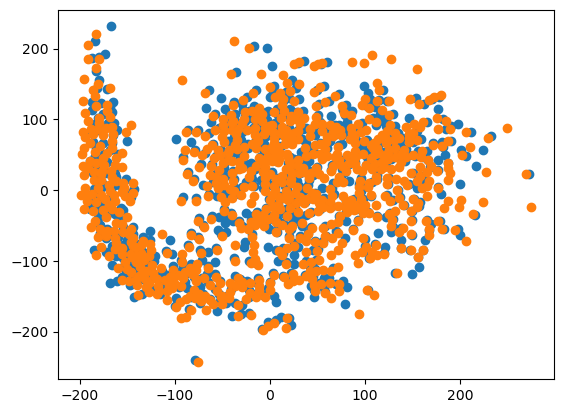

In [45]:
#plt.scatter(np.array(CoM1).T[0], np.array(CoM1).T[1])
plt.scatter(np.array(CoM2).T[0], np.array(CoM2).T[1])
plt.scatter(np.array(CoM3).T[0], np.array(CoM3).T[1])

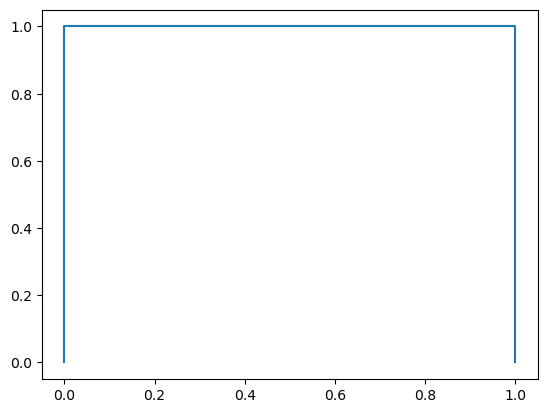

In [107]:
from hilbertcurve.hilbertcurve import HilbertCurve
p=1
n=2
hilbert_curve = HilbertCurve(p, n)
distances = list(range(2**(n*p)))
points = hilbert_curve.points_from_distances(distances)
plt.plot((np.array(points).T[0] - 2**(p-1) + 1), (np.array(points).T[1] - 2**(p-1) + 1))

In [92]:
m = np.array(list((np.array(points), np.array(points))))

In [108]:
points

[[0, 0], [0, 1], [1, 1], [1, 0]]

In [93]:
from itertools import chain

def flatten_chain(matrix):
    return list(chain.from_iterable(matrix))

flatten_chain(m)

[array([0, 0]),
 array([0, 1]),
 array([1, 1]),
 array([1, 0]),
 array([0, 0]),
 array([0, 1]),
 array([1, 1]),
 array([1, 0])]

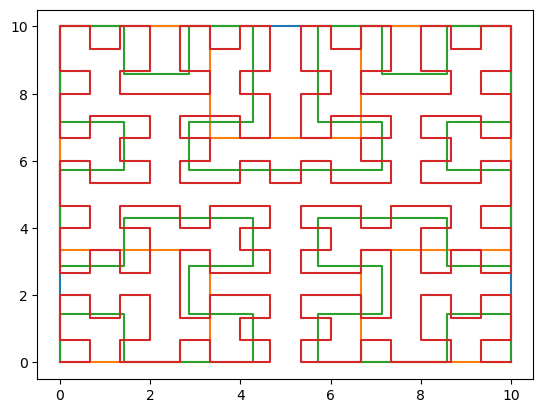

In [199]:
for i in range(4):
    size = 10
    n = 2
    hilbert_curve = HilbertCurve(i+1, n)
    distances = list(range(2**(n*(i+1))))
    points = np.array(hilbert_curve.points_from_distances(distances))*(size/(2**(i+1)-1))
    plt.plot(np.array(points).T[0], np.array(points).T[1])

In [230]:
np.mean(np.array(CoM1)[:,0])

1.3562640289596298e-13

In [52]:
from hilbertcurve.hilbertcurve import HilbertCurve
from tqdm.notebook import tqdm
from itertools import chain
import math
def matcher(A,B, iterations):
    size = 300 
    n = 2
    for i in tqdm(range(iterations)):
        for s in range(iterations):
            hilbert_curve = HilbertCurve(i+1, n)
            distances = list(range(2**(n*(i+1))))
            points = np.array(hilbert_curve.points_from_distances(distances))*(2*size/(2**(i+1)-1))-(size)
            cubes_A = []
            cubes_B = []
            for j in range(len(points)):        #(2**(n*(i+1)))
                col0A = (A[:,0]>=points[j][0] - (size/(2**(i)))) & (A[:,0]<=points[j][0] + (size/(2**(i))))
                col1A = (A[:,1]>=points[j][1] - (size/(2**(i)))) & (A[:,1]<=points[j][1] + (size/(2**(i))))
                cubes_A.append(A[col0A & col1A])
                col0B = (B[:,0]>=points[j][0] - (size/(2**(i)))) & (B[:,0]<=points[j][0] + (size/(2**(i))))
                col1B = (B[:,1]>=points[j][1] - (size/(2**(i)))) & (B[:,1]<=points[j][1] + (size/(2**(i))))
                cubes_B.append(B[col0B & col1B])
            #print(cubes_A)
            for k in tqdm(range(len(cubes_A))):
                com_A = np.mean(cubes_A[k][:,0])
                com_B = np.mean(cubes_B[k][:,0])
                #print(com_A, com_B)
                if math.isnan(com_A) or math.isnan(com_B) == True:
                    cubes_B[k][:,0] = cubes_B[k][:,0]*com_B/com_A
                else:
                    cubes_B[k][:,0] = cubes_B[k][:,0]
                com_A = np.mean(cubes_A[k][:,1])
                com_B = np.mean(cubes_B[k][:,1])
                #print(com_A, com_B)
                if math.isnan(com_A) or math.isnan(com_B) == True:
                    cubes_B[k][:,1] = cubes_B[k][:,1]*com_B/com_A
                else:
                    cubes_B[k][:,1] = cubes_B[k][:,1]
            B = np.array(list(chain.from_iterable(cubes_B)))
    plt.scatter(A.T[0], A.T[1])
        #plt.plot(np.array(points).T[0], np.array(points).T[1])
    plt.scatter(B.T[0], B.T[1])
    return B

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

array([[ -75.70042449, -243.62201325],
       [ -75.70042449, -243.62201325],
       [ -75.70042449, -243.62201325],
       ...,
       [  17.87654201, -180.87393137],
       [  93.82841997, -174.55983414],
       [  63.90353591, -152.51213375]])

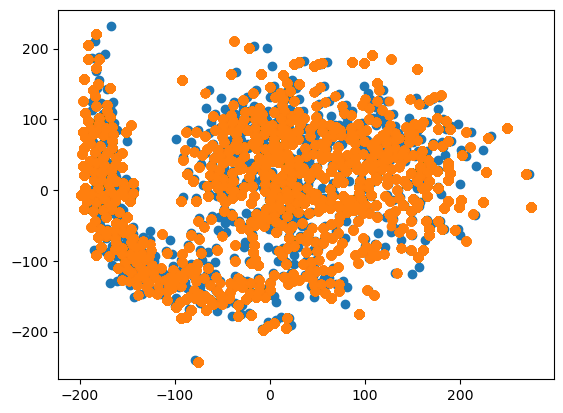

In [53]:
matcher((np.array(CoM2)), (np.array(CoM3)), 3)

In [48]:
from hilbertcurve.hilbertcurve import HilbertCurve
from tqdm.notebook import tqdm
from itertools import chain
import math
def matcher(A,B, iterations):
    size = 300 
    n = 2
    for i in tqdm(range(iterations)):
        hilbert_curve = HilbertCurve(i+1, n)
        distances = list(range(2**(n*(i+1))))
        points = np.array(hilbert_curve.points_from_distances(distances))*(2*size/(2**(i+1)-1))-(size)
        cubes_A = []
        cubes_B = []
        for j in range(len(points)):        #(2**(n*(i+1)))
            col0A = (A[:,0]>=points[j][0] - (size/(2**(i)))) & (A[:,0]<=points[j][0] + (size/(2**(i))))
            col1A = (A[:,1]>=points[j][1] - (size/(2**(i)))) & (A[:,1]<=points[j][1] + (size/(2**(i))))
            cubes_A.append(A[col0A & col1A])
            col0B = (B[:,0]>=points[j][0] - (size/(2**(i)))) & (B[:,0]<=points[j][0] + (size/(2**(i))))
            col1B = (B[:,1]>=points[j][1] - (size/(2**(i)))) & (B[:,1]<=points[j][1] + (size/(2**(i))))
            cubes_B.append(B[col0B & col1B])
        #print(cubes_A)
        for k in tqdm(range(len(cubes_A))):
            com_A = np.mean(cubes_A[k][:,0])
            com_B = np.mean(cubes_B[k][:,0])
            #print(com_A, com_B)
            if math.isnan(com_A) or math.isnan(com_B) == True:
                cubes_B[k][:,0] = cubes_B[k][:,0]*com_B/com_A
            else:
                cubes_B[k][:,0] = cubes_B[k][:,0]
            com_A = np.mean(cubes_A[k][:,1])
            com_B = np.mean(cubes_B[k][:,1])
            #print(com_A, com_B)
            if math.isnan(com_A) or math.isnan(com_B) == True:
                cubes_B[k][:,1] = cubes_B[k][:,1]*com_B/com_A
            else:
                cubes_B[k][:,1] = cubes_B[k][:,1]
        B = np.array(list(chain.from_iterable(cubes_B)))
    plt.scatter(A.T[0], A.T[1])
        #plt.plot(np.array(points).T[0], np.array(points).T[1])
    plt.scatter(B.T[0], B.T[1])
    return B

In [51]:
from hilbertcurve.hilbertcurve import HilbertCurve
from tqdm.notebook import tqdm
from itertools import chain
import math
def matcher(A,B, iterations):
    size = 300 
    n = 2
    for i in tqdm(range(iterations*10)):
        hilbert_curve = HilbertCurve(iterations+1, n)
        distances = list(range(2**(n*(iterations+1))))
        points = np.array(hilbert_curve.points_from_distances(distances))*(2*size/(2**(iterations+1)-1))-(size)
        cubes_A = []
        cubes_B = []
        for j in range(len(points)):        #(2**(n*(i+1)))
            col0A = (A[:,0]>=points[j][0] - (size/(2**(iterations)))) & (A[:,0]<=points[j][0] + (size/(2**(iterations))))
            col1A = (A[:,1]>=points[j][1] - (size/(2**(iterations)))) & (A[:,1]<=points[j][1] + (size/(2**(iterations))))
            cubes_A.append(A[col0A & col1A])
            col0B = (B[:,0]>=points[j][0] - (size/(2**(iterations)))) & (B[:,0]<=points[j][0] + (size/(2**(iterations))))
            col1B = (B[:,1]>=points[j][1] - (size/(2**(iterations)))) & (B[:,1]<=points[j][1] + (size/(2**(iterations))))
            cubes_B.append(B[col0B & col1B])
        #print(cubes_A)
        for k in tqdm(range(len(cubes_A))):
            com_A = np.mean(cubes_A[k][:,0])
            com_B = np.mean(cubes_B[k][:,0])
            #print(com_A, com_B)
            if math.isnan(com_A) or math.isnan(com_B) == True:
                cubes_B[k][:,0] = cubes_B[k][:,0]*com_B/com_A
            else:
                cubes_B[k][:,0] = cubes_B[k][:,0]
            com_A = np.mean(cubes_A[k][:,1])
            com_B = np.mean(cubes_B[k][:,1])
            #print(com_A, com_B)
            if math.isnan(com_A) or math.isnan(com_B) == True:
                cubes_B[k][:,1] = cubes_B[k][:,1]*com_B/com_A
            else:
                cubes_B[k][:,1] = cubes_B[k][:,1]
        B = np.array(list(chain.from_iterable(cubes_B)))
    plt.scatter(A.T[0], A.T[1])
        #plt.plot(np.array(points).T[0], np.array(points).T[1])
    plt.scatter(B.T[0], B.T[1])
    return B

array([[-139.59932871, -120.02435276],
       [-150.69152574, -136.41640707],
       [-140.22818266, -148.1521873 ],
       ...,
       [ -11.60768076,  -33.97310995],
       [-190.25081696,   14.03306961],
       [-136.23908037, -129.76616735]])

In [106]:
a = np.array(CoM1)

col0m = (a[:,0]>=-10) & (a[:,0]<=0)
col1m = (a[:,1]>=-9) & (a[:,1]<=1)

a[col0m & col1m]

array([], shape=(0, 2), dtype=float64)

In [25]:
transf, (source_list, target_list) = aa.find_transform((np.array(CoM1)), (np.array(CoM2)))

MaxIterError: List of matching triangles exhausted before an acceptable transformation was found

In [72]:
CoM1

AttributeError: 'list' object has no attribute 'T'

In [65]:
import cv2
def align_images(imageGray, templateGray, maxFeatures=500, keepPercent=0.2,
	debug=False):
	# convert both the input image and template to grayscale
	#imageGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
	#templateGray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
	# use ORB to detect keypoints and extract (binary) local
	# invariant features
	orb = cv2.ORB_create(maxFeatures)
	(kpsA, descsA) = orb.detectAndCompute(imageGray, None)
	(kpsB, descsB) = orb.detectAndCompute(templateGray, None)
	# match the features
	method = cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING
	matcher = cv2.DescriptorMatcher_create(method)
	matches = matcher.match(descsA, descsB, None)
    


	# sort the matches by their distance (the smaller the distance,
	# the "more similar" the features are)
	matches = sorted(matches, key=lambda x:x.distance)
	# keep only the top matches
	keep = int(len(matches) * keepPercent)
	matches = matches[:keep]
    
	# check to see if we should visualize the matched keypoints
	if debug:
		matchedVis = cv2.drawMatches(image, kpsA, template, kpsB,
			matches, None)
		matchedVis = imutils.resize(matchedVis, width=1000)
		cv2.imshow("Matched Keypoints", matchedVis)
		cv2.waitKey(0)
        
    # allocate memory for the keypoints (x, y)-coordinates from the
	# top matches -- we'll use these coordinates to compute our
	# homography matrix
	ptsA = np.zeros((len(matches), 2), dtype="float")
	ptsB = np.zeros((len(matches), 2), dtype="float")
    
	#print(matches)
	#print(ptsB)
	# loop over the top matches
	for (i, m) in enumerate(matches):
		# indicate that the two keypoints in the respective images
		# map to each other
		ptsA[i] = kpsA[m.queryIdx].pt
		ptsB[i] = kpsB[m.trainIdx].pt
        
        
        
	# compute the homography matrix between the two sets of matched
	# points
	(H, mask) = cv2.findHomography(ptsA, ptsB, method=cv2.RANSAC)
	# use the homography matrix to align the images
	(h, w) = template.shape[:2]
	aligned = cv2.warpPerspective(image, H, (w, h))
	# return the aligned image
	return aligned
cv2.imshow( np.array(CoM1))
#aligned = align_images(CoM2, CoM1, maxFeatures=500, keepPercent=0.2, debug=False)

error: OpenCV(4.9.0) :-1: error: (-5:Bad argument) in function 'imshow'
> Overload resolution failed:
>  - imshow() missing required argument 'mat' (pos 2)
>  - imshow() missing required argument 'mat' (pos 2)
>  - imshow() missing required argument 'mat' (pos 2)


In [35]:
data_new = (pd.DataFrame(data_new))

In [70]:
data_new["coordinates_split"] = data_new["coordinates"].str.split(',')

In [112]:
data_new['index'] =  list(range(len(data_new.index)))

In [8]:
data_new

,coordinates,CoM,neuron_id
0,"[[nan, nan], [256.33911940731105, 73.0], [256....","[66.2468543153045, 248.29923720904148]",1
1,"[[nan, nan], [244.19779976012222, 51.0], [244....","[55.15465728893198, 231.90718289741946]",2
2,"[[nan, nan], [232.0735438450976, 70.0], [232.2...","[65.61800037380095, 220.17140266741066]",3
3,"[[nan, nan], [258.0465674633728, 39.0], [258.3...","[38.91343984544794, 246.75943588558735]",4
4,"[[nan, nan], [253.01052603304944, 57.0], [253....","[60.38026280961385, 242.85377134683736]",5
...,...,...,...
907,"[[nan, nan], [379.7121456228647, 162.0], [379....","[151.80396104904065, 367.0438550779104]",908
908,"[[nan, nan], [440.1590523948682, 225.0], [440....","[221.38073761452617, 434.8402706411695]",909
909,"[[nan, nan], [343.3579581100828, 200.0], [343....","[194.2385022741261, 334.3504800219589]",910
910,"[[nan, nan], [388.1060949651373, 21.0], [388.2...","[15.595366068594368, 382.3566595782675]",911


In [36]:
a = list(data_new["CoM"])

In [37]:
for i in  range(len(a)):
    a[i] = list(a[i])

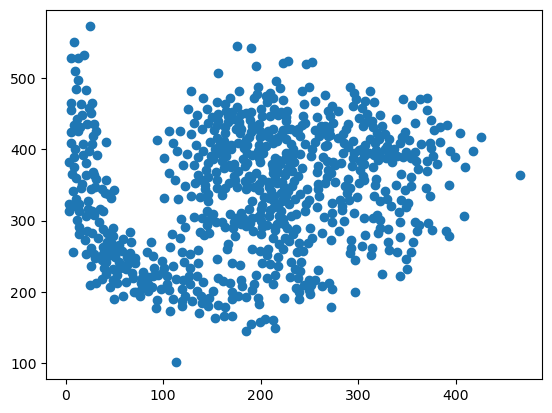

In [38]:
plt.scatter(np.array(a).T[0], np.array(a).T[1])

In [9]:
import pickle
with open('data/data_ht1.pkl', 'rb') as f:
    data_ht_1 = pickle.load(f)

In [10]:
data_ht_1 = (pd.DataFrame(data_ht_1))

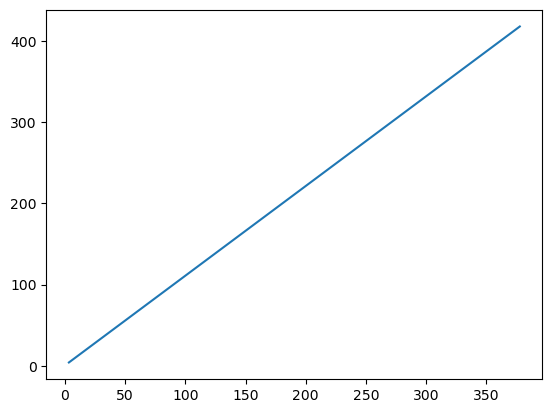

In [26]:
plt.plot(np.array(data_ht_1["CoM"])[0], np.array(data_ht_1["CoM"])[1]  )

In [13]:
import pickle
with open('data/data_merge.pkl', 'rb') as f:
    data_merge = pickle.load(f)

In [14]:
np.array(pd.DataFrame(data_merge))

array([[5, array([  5.85067288, 366.39927686]),
        array([0, 0, 0, ..., 0, 0, 0])],
       [12, array([  8.61527573, 324.33547129]),
        array([1, 1, 1, ..., 0, 0, 0])],
       [12, array([  8.61527573, 324.33547129]),
        array([1, 1, 1, ..., 0, 0, 0])],
       ...,
       [902, array([406.10224527, 436.54056115]),
        array([0, 0, 0, ..., 0, 0, 0])],
       [908, array([424.06750624, 371.78010835]),
        array([0, 0, 0, ..., 0, 0, 0])],
       [908, array([424.06750624, 371.78010835]),
        array([0, 0, 0, ..., 0, 0, 0])]], dtype=object)

In [15]:
pd.DataFrame(data_merge)[['']]

KeyError: "None of [Index([''], dtype='object')] are in the [columns]"

In [20]:
data22 = pd.read_pickle(r'~/Documents/git/msu_neuroscience/notebooks/Sahsa/CA1_22_neurons_intersection.pkl')

In [19]:
data22

,id,CoM,C,C2,C3
0,5,"[5.850672877290407, 366.39927685736143]","[0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,12,"[8.615275734634045, 324.3354712939186]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,13,"[9.290660420100682, 375.4025227205757]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,14,"[9.58986943360392, 463.17709640295186]","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ..."
4,15,"[10.745623895316688, 423.4844060720442]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...
323,897,"[398.0233740453151, 397.5395042580116]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
324,900,"[399.352860484587, 294.34276731732217]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
325,901,"[401.9414834731526, 274.39508498761705]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, ...","[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
326,902,"[406.1022452659691, 436.540561149087]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [171]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
from tqdm.notebook import tqdm

data22 = pd.read_pickle(r'~/Documents/git/msu_neuroscience/notebooks/Sahsa/CA1_22_neurons_intersection.pkl')
data23 = pd.read_pickle(r'~/Documents/git/msu_neuroscience/notebooks/Sahsa/CA1_23_neurons_intersection.pkl')
data24 = pd.read_pickle(r'~/Documents/git/msu_neuroscience/notebooks/Sahsa/CA1_24_neurons_intersection.pkl')
data25 = pd.read_pickle(r'~/Documents/git/msu_neuroscience/notebooks/Sahsa/CA1_25_neurons_intersection.pkl')
data = [data22, data23, data24, data25]
global_data = list()
global_graph_dyns = list()
for i in tqdm(range(len(data))):
    D = list()
    D0 = (np.array(data[i][['C']]))
    D0 = D0.tolist()
    E0 = [list(l[0]) for l in D0]
    D1 = (np.array(data[i][['C2']]))
    D1 = D1.tolist()
    E1 = [list(l[0]) for l in D1]
    D1 = np.array(E1)
    D2 = (np.array(data[i][['C3']]))
    D2 = D2.tolist()
    E2 = [list(l[0]) for l in D2]
    D2 = np.array(E2)
    D.append(np.array(E0))
    D.append(np.array(E1))
    D.append(np.array(E2))
    dynamics = list()
    
    for j in tqdm(range(len(D))):
        print('circle', j)
        graph_dyns = list()
        df_norm = pd.DataFrame(D[j].T)
        slices = get_slices(dataframe=df_norm, n=20)
        
        graphs, edge_lists = list(), list()
        k = 0
        for slice in slices:
            if len(slice) < 100:
                print(f"WARNING: too small slice({len(slice)} entries), ignoring")
                continue
            graph, edges = build_graph(coh, dataframe=slice)
            plot_graph_pyvis(edges, 0.6, name="coh_graph_slice_%d" % k)
            graphs.append(graph)
            edge_lists.append(edges)
            graph_dyns.append(len(edges))
            k += 1
        print('doing dynamics')
        global_graph_dyns.append(graph_dyns)
        dynamics_tmp = list()
        for edges in edge_lists:
            #if len(edges) < 100:
            #    continue
            avg = sum([edge.rho for edge in edges])
            avg /= len(edges)
            dynamics_tmp.append(avg)
            #sns.plot(dynamics_tmp)
            #plt.show()
        dynamics.append(dynamics_tmp)
        print('still alive')
    global_data.append(dynamics)
    print('yes, still alive')
    #plt.title("Dynamics of $\\bar\\rho$ over slices")
    #sns.plot(np.array(dynamics).T[:])
    #plt.show()
    #plt.imsave('mouse'+i+'.png')
    
    

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

circle 0


  0%|          | 0/328 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/107256 [00:00<?, ?it/s]

There's 1466 edges
There is 328 nodes in graph


  0%|          | 0/328 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/107256 [00:00<?, ?it/s]

There's 2519 edges
There is 328 nodes in graph


  0%|          | 0/328 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/107256 [00:00<?, ?it/s]

There's 4969 edges
There is 328 nodes in graph


  0%|          | 0/328 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/107256 [00:00<?, ?it/s]

There's 5328 edges
There is 328 nodes in graph


  0%|          | 0/328 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/107256 [00:00<?, ?it/s]

There's 2005 edges
There is 328 nodes in graph


  0%|          | 0/328 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/107256 [00:00<?, ?it/s]

There's 2976 edges
There is 328 nodes in graph


  0%|          | 0/328 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/107256 [00:00<?, ?it/s]

There's 947 edges
There is 328 nodes in graph


  0%|          | 0/328 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/107256 [00:00<?, ?it/s]

There's 3208 edges
There is 328 nodes in graph


  0%|          | 0/328 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/107256 [00:00<?, ?it/s]

There's 400 edges
There is 328 nodes in graph


  0%|          | 0/328 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/107256 [00:00<?, ?it/s]

There's 783 edges
There is 328 nodes in graph


  0%|          | 0/328 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/107256 [00:00<?, ?it/s]

There's 1225 edges
There is 328 nodes in graph


  0%|          | 0/328 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/107256 [00:00<?, ?it/s]

There's 244 edges
There is 328 nodes in graph


  0%|          | 0/328 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/107256 [00:00<?, ?it/s]

There's 153 edges
There is 328 nodes in graph


  0%|          | 0/328 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/107256 [00:00<?, ?it/s]

There's 2418 edges
There is 328 nodes in graph


  0%|          | 0/328 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/107256 [00:00<?, ?it/s]

There's 834 edges
There is 328 nodes in graph


  0%|          | 0/328 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/107256 [00:00<?, ?it/s]

There's 1481 edges
There is 328 nodes in graph


  0%|          | 0/328 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/107256 [00:00<?, ?it/s]

There's 1260 edges
There is 328 nodes in graph


  0%|          | 0/328 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/107256 [00:00<?, ?it/s]

There's 1539 edges
There is 328 nodes in graph


  0%|          | 0/328 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/107256 [00:00<?, ?it/s]

There's 304 edges
There is 328 nodes in graph


  0%|          | 0/328 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/107256 [00:00<?, ?it/s]

There's 2370 edges
There is 328 nodes in graph
doing dynamics
still alive
circle 1


  0%|          | 0/328 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/107256 [00:00<?, ?it/s]

There's 5807 edges
There is 328 nodes in graph


  0%|          | 0/328 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/107256 [00:00<?, ?it/s]

There's 5241 edges
There is 328 nodes in graph


  0%|          | 0/328 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/107256 [00:00<?, ?it/s]

There's 13849 edges
There is 328 nodes in graph


  0%|          | 0/328 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/107256 [00:00<?, ?it/s]

There's 22064 edges
There is 328 nodes in graph


  0%|          | 0/328 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/107256 [00:00<?, ?it/s]

There's 17845 edges
There is 328 nodes in graph


  0%|          | 0/328 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/107256 [00:00<?, ?it/s]

There's 24502 edges
There is 328 nodes in graph


  0%|          | 0/328 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/107256 [00:00<?, ?it/s]

There's 3471 edges
There is 328 nodes in graph


  0%|          | 0/328 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/107256 [00:00<?, ?it/s]

There's 1815 edges
There is 328 nodes in graph


  0%|          | 0/328 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/107256 [00:00<?, ?it/s]

There's 4360 edges
There is 328 nodes in graph


  0%|          | 0/328 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/107256 [00:00<?, ?it/s]

There's 7199 edges
There is 328 nodes in graph


  0%|          | 0/328 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/107256 [00:00<?, ?it/s]

There's 3650 edges
There is 328 nodes in graph


  0%|          | 0/328 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/107256 [00:00<?, ?it/s]

There's 19746 edges
There is 328 nodes in graph


  0%|          | 0/328 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/107256 [00:00<?, ?it/s]

There's 6330 edges
There is 328 nodes in graph


  0%|          | 0/328 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/107256 [00:00<?, ?it/s]

There's 4433 edges
There is 328 nodes in graph


  0%|          | 0/328 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/107256 [00:00<?, ?it/s]

There's 5547 edges
There is 328 nodes in graph


  0%|          | 0/328 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/107256 [00:00<?, ?it/s]

There's 10850 edges
There is 328 nodes in graph


  0%|          | 0/328 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/107256 [00:00<?, ?it/s]

There's 16733 edges
There is 328 nodes in graph


  0%|          | 0/328 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/107256 [00:00<?, ?it/s]

There's 4402 edges
There is 328 nodes in graph


  0%|          | 0/328 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/107256 [00:00<?, ?it/s]

There's 5219 edges
There is 328 nodes in graph


  0%|          | 0/328 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/107256 [00:00<?, ?it/s]

There's 11097 edges
There is 328 nodes in graph
doing dynamics
still alive
circle 2


  0%|          | 0/328 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/107256 [00:00<?, ?it/s]

There's 2550 edges
There is 328 nodes in graph


  0%|          | 0/328 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/107256 [00:00<?, ?it/s]

There's 23745 edges
There is 328 nodes in graph


  0%|          | 0/328 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/107256 [00:00<?, ?it/s]

There's 7911 edges
There is 328 nodes in graph


  0%|          | 0/328 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/107256 [00:00<?, ?it/s]

There's 6772 edges
There is 328 nodes in graph


  0%|          | 0/328 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/107256 [00:00<?, ?it/s]

There's 12837 edges
There is 328 nodes in graph


  0%|          | 0/328 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/107256 [00:00<?, ?it/s]

There's 70 edges
There is 328 nodes in graph


  0%|          | 0/328 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/107256 [00:00<?, ?it/s]

There's 2145 edges
There is 328 nodes in graph


  0%|          | 0/328 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/107256 [00:00<?, ?it/s]

There's 960 edges
There is 328 nodes in graph


  0%|          | 0/328 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/107256 [00:00<?, ?it/s]

There's 15109 edges
There is 328 nodes in graph


  0%|          | 0/328 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/107256 [00:00<?, ?it/s]

There's 1953 edges
There is 328 nodes in graph


  0%|          | 0/328 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/107256 [00:00<?, ?it/s]

There's 4236 edges
There is 328 nodes in graph


  0%|          | 0/328 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/107256 [00:00<?, ?it/s]

There's 7725 edges
There is 328 nodes in graph


  0%|          | 0/328 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/107256 [00:00<?, ?it/s]

There's 1685 edges
There is 328 nodes in graph


  0%|          | 0/328 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/107256 [00:00<?, ?it/s]

There's 8894 edges
There is 328 nodes in graph


  0%|          | 0/328 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/107256 [00:00<?, ?it/s]

There's 4035 edges
There is 328 nodes in graph


  0%|          | 0/328 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/107256 [00:00<?, ?it/s]

There's 7106 edges
There is 328 nodes in graph


  0%|          | 0/328 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/107256 [00:00<?, ?it/s]

There's 3028 edges
There is 328 nodes in graph


  0%|          | 0/328 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/107256 [00:00<?, ?it/s]

There's 1084 edges
There is 328 nodes in graph


  0%|          | 0/328 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/107256 [00:00<?, ?it/s]

There's 4780 edges
There is 328 nodes in graph


  0%|          | 0/328 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/107256 [00:00<?, ?it/s]

There's 8467 edges
There is 328 nodes in graph
doing dynamics
still alive
yes, still alive


  0%|          | 0/3 [00:00<?, ?it/s]

circle 0


  0%|          | 0/83 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/6806 [00:00<?, ?it/s]

There's 2 edges
There is 83 nodes in graph


  0%|          | 0/83 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/6806 [00:00<?, ?it/s]

There's 2 edges
There is 83 nodes in graph


  0%|          | 0/83 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/6806 [00:00<?, ?it/s]

There's 0 edges
There is 83 nodes in graph


  0%|          | 0/83 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/6806 [00:00<?, ?it/s]

There's 2 edges
There is 83 nodes in graph


  0%|          | 0/83 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/6806 [00:00<?, ?it/s]

There's 4 edges
There is 83 nodes in graph


  0%|          | 0/83 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/6806 [00:00<?, ?it/s]

There's 169 edges
There is 83 nodes in graph


  0%|          | 0/83 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/6806 [00:00<?, ?it/s]

There's 30 edges
There is 83 nodes in graph


  0%|          | 0/83 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/6806 [00:00<?, ?it/s]

There's 4 edges
There is 83 nodes in graph


  0%|          | 0/83 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/6806 [00:00<?, ?it/s]

There's 2 edges
There is 83 nodes in graph


  0%|          | 0/83 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/6806 [00:00<?, ?it/s]

There's 166 edges
There is 83 nodes in graph


  0%|          | 0/83 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/6806 [00:00<?, ?it/s]

There's 166 edges
There is 83 nodes in graph


  0%|          | 0/83 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/6806 [00:00<?, ?it/s]

There's 0 edges
There is 83 nodes in graph


  0%|          | 0/83 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/6806 [00:00<?, ?it/s]

There's 12 edges
There is 83 nodes in graph


  0%|          | 0/83 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/6806 [00:00<?, ?it/s]

There's 22 edges
There is 83 nodes in graph


  0%|          | 0/83 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/6806 [00:00<?, ?it/s]

There's 6 edges
There is 83 nodes in graph


  0%|          | 0/83 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/6806 [00:00<?, ?it/s]

There's 8 edges
There is 83 nodes in graph


  0%|          | 0/83 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/6806 [00:00<?, ?it/s]

There's 21 edges
There is 83 nodes in graph


  0%|          | 0/83 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/6806 [00:00<?, ?it/s]

There's 11 edges
There is 83 nodes in graph


  0%|          | 0/83 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/6806 [00:00<?, ?it/s]

There's 10 edges
There is 83 nodes in graph


  0%|          | 0/83 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/6806 [00:00<?, ?it/s]

There's 18 edges
There is 83 nodes in graph
doing dynamics
still alive
circle 1


  0%|          | 0/83 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/6806 [00:00<?, ?it/s]

There's 194 edges
There is 83 nodes in graph


  0%|          | 0/83 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/6806 [00:00<?, ?it/s]

There's 236 edges
There is 83 nodes in graph


  0%|          | 0/83 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/6806 [00:00<?, ?it/s]

There's 38 edges
There is 83 nodes in graph


  0%|          | 0/83 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/6806 [00:00<?, ?it/s]

There's 104 edges
There is 83 nodes in graph


  0%|          | 0/83 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/6806 [00:00<?, ?it/s]

There's 92 edges
There is 83 nodes in graph


  0%|          | 0/83 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/6806 [00:00<?, ?it/s]

There's 48 edges
There is 83 nodes in graph


  0%|          | 0/83 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/6806 [00:00<?, ?it/s]

There's 46 edges
There is 83 nodes in graph


  0%|          | 0/83 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/6806 [00:00<?, ?it/s]

There's 12 edges
There is 83 nodes in graph


  0%|          | 0/83 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/6806 [00:00<?, ?it/s]

There's 193 edges
There is 83 nodes in graph


  0%|          | 0/83 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/6806 [00:00<?, ?it/s]

There's 344 edges
There is 83 nodes in graph


  0%|          | 0/83 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/6806 [00:00<?, ?it/s]

There's 184 edges
There is 83 nodes in graph


  0%|          | 0/83 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/6806 [00:00<?, ?it/s]

There's 261 edges
There is 83 nodes in graph


  0%|          | 0/83 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/6806 [00:00<?, ?it/s]

There's 207 edges
There is 83 nodes in graph


  0%|          | 0/83 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/6806 [00:00<?, ?it/s]

There's 1075 edges
There is 83 nodes in graph


  0%|          | 0/83 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/6806 [00:00<?, ?it/s]

There's 881 edges
There is 83 nodes in graph


  0%|          | 0/83 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/6806 [00:00<?, ?it/s]

There's 255 edges
There is 83 nodes in graph


  0%|          | 0/83 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/6806 [00:00<?, ?it/s]

There's 351 edges
There is 83 nodes in graph


  0%|          | 0/83 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/6806 [00:00<?, ?it/s]

There's 200 edges
There is 83 nodes in graph


  0%|          | 0/83 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/6806 [00:00<?, ?it/s]

There's 259 edges
There is 83 nodes in graph


  0%|          | 0/83 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/6806 [00:00<?, ?it/s]

There's 654 edges
There is 83 nodes in graph
doing dynamics
still alive
circle 2


  0%|          | 0/83 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/6806 [00:00<?, ?it/s]

There's 190 edges
There is 83 nodes in graph


  0%|          | 0/83 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/6806 [00:00<?, ?it/s]

There's 488 edges
There is 83 nodes in graph


  0%|          | 0/83 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/6806 [00:00<?, ?it/s]

There's 498 edges
There is 83 nodes in graph


  0%|          | 0/83 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/6806 [00:00<?, ?it/s]

There's 506 edges
There is 83 nodes in graph


  0%|          | 0/83 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/6806 [00:00<?, ?it/s]

There's 14 edges
There is 83 nodes in graph


  0%|          | 0/83 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/6806 [00:00<?, ?it/s]

There's 168 edges
There is 83 nodes in graph


  0%|          | 0/83 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/6806 [00:00<?, ?it/s]

There's 488 edges
There is 83 nodes in graph


  0%|          | 0/83 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/6806 [00:00<?, ?it/s]

There's 180 edges
There is 83 nodes in graph


  0%|          | 0/83 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/6806 [00:00<?, ?it/s]

There's 33 edges
There is 83 nodes in graph


  0%|          | 0/83 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/6806 [00:00<?, ?it/s]

There's 370 edges
There is 83 nodes in graph


  0%|          | 0/83 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/6806 [00:00<?, ?it/s]

There's 164 edges
There is 83 nodes in graph


  0%|          | 0/83 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/6806 [00:00<?, ?it/s]

There's 328 edges
There is 83 nodes in graph


  0%|          | 0/83 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/6806 [00:00<?, ?it/s]

There's 2 edges
There is 83 nodes in graph


  0%|          | 0/83 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/6806 [00:00<?, ?it/s]

There's 24 edges
There is 83 nodes in graph


  0%|          | 0/83 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/6806 [00:00<?, ?it/s]

There's 168 edges
There is 83 nodes in graph


  0%|          | 0/83 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/6806 [00:00<?, ?it/s]

There's 188 edges
There is 83 nodes in graph


  0%|          | 0/83 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/6806 [00:00<?, ?it/s]

There's 4 edges
There is 83 nodes in graph


  0%|          | 0/83 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/6806 [00:00<?, ?it/s]

There's 176 edges
There is 83 nodes in graph


  0%|          | 0/83 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/6806 [00:00<?, ?it/s]

There's 328 edges
There is 83 nodes in graph


  0%|          | 0/83 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/6806 [00:00<?, ?it/s]

There's 512 edges
There is 83 nodes in graph
doing dynamics
still alive
yes, still alive


  0%|          | 0/3 [00:00<?, ?it/s]

circle 0


  0%|          | 0/67 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4422 [00:00<?, ?it/s]

There's 68 edges
There is 67 nodes in graph


  0%|          | 0/67 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4422 [00:00<?, ?it/s]

There's 215 edges
There is 67 nodes in graph


  0%|          | 0/67 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4422 [00:00<?, ?it/s]

There's 123 edges
There is 67 nodes in graph


  0%|          | 0/67 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4422 [00:00<?, ?it/s]

There's 131 edges
There is 67 nodes in graph


  0%|          | 0/67 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4422 [00:00<?, ?it/s]

There's 148 edges
There is 67 nodes in graph


  0%|          | 0/67 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4422 [00:00<?, ?it/s]

There's 143 edges
There is 67 nodes in graph


  0%|          | 0/67 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4422 [00:00<?, ?it/s]

There's 86 edges
There is 67 nodes in graph


  0%|          | 0/67 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4422 [00:00<?, ?it/s]

There's 229 edges
There is 67 nodes in graph


  0%|          | 0/67 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4422 [00:00<?, ?it/s]

There's 200 edges
There is 67 nodes in graph


  0%|          | 0/67 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4422 [00:00<?, ?it/s]

There's 123 edges
There is 67 nodes in graph


  0%|          | 0/67 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4422 [00:00<?, ?it/s]

There's 118 edges
There is 67 nodes in graph


  0%|          | 0/67 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4422 [00:00<?, ?it/s]

There's 226 edges
There is 67 nodes in graph


  0%|          | 0/67 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4422 [00:00<?, ?it/s]

There's 43 edges
There is 67 nodes in graph


  0%|          | 0/67 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4422 [00:00<?, ?it/s]

There's 53 edges
There is 67 nodes in graph


  0%|          | 0/67 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4422 [00:00<?, ?it/s]

There's 194 edges
There is 67 nodes in graph


  0%|          | 0/67 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4422 [00:00<?, ?it/s]

There's 84 edges
There is 67 nodes in graph


  0%|          | 0/67 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4422 [00:00<?, ?it/s]

There's 203 edges
There is 67 nodes in graph


  0%|          | 0/67 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4422 [00:00<?, ?it/s]

There's 44 edges
There is 67 nodes in graph


  0%|          | 0/67 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4422 [00:00<?, ?it/s]

There's 48 edges
There is 67 nodes in graph


  0%|          | 0/67 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4422 [00:00<?, ?it/s]

There's 94 edges
There is 67 nodes in graph
doing dynamics
still alive
circle 1


  0%|          | 0/67 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4422 [00:00<?, ?it/s]

There's 4422 edges
There is 67 nodes in graph


  0%|          | 0/67 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4422 [00:00<?, ?it/s]

There's 4422 edges
There is 67 nodes in graph


  0%|          | 0/67 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4422 [00:00<?, ?it/s]

There's 4422 edges
There is 67 nodes in graph


  0%|          | 0/67 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4422 [00:00<?, ?it/s]

There's 4422 edges
There is 67 nodes in graph


  0%|          | 0/67 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4422 [00:00<?, ?it/s]

There's 4422 edges
There is 67 nodes in graph


  0%|          | 0/67 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4422 [00:00<?, ?it/s]

There's 4422 edges
There is 67 nodes in graph


  0%|          | 0/67 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4422 [00:00<?, ?it/s]

There's 4422 edges
There is 67 nodes in graph


  0%|          | 0/67 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4422 [00:00<?, ?it/s]

There's 4422 edges
There is 67 nodes in graph


  0%|          | 0/67 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4422 [00:00<?, ?it/s]

There's 4422 edges
There is 67 nodes in graph


  0%|          | 0/67 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4422 [00:00<?, ?it/s]

There's 4422 edges
There is 67 nodes in graph


  0%|          | 0/67 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4422 [00:00<?, ?it/s]

There's 4422 edges
There is 67 nodes in graph


  0%|          | 0/67 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4422 [00:00<?, ?it/s]

There's 4422 edges
There is 67 nodes in graph


  0%|          | 0/67 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4422 [00:00<?, ?it/s]

There's 4422 edges
There is 67 nodes in graph


  0%|          | 0/67 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4422 [00:00<?, ?it/s]

There's 4422 edges
There is 67 nodes in graph


  0%|          | 0/67 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4422 [00:00<?, ?it/s]

There's 4422 edges
There is 67 nodes in graph


  0%|          | 0/67 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4422 [00:00<?, ?it/s]

There's 4422 edges
There is 67 nodes in graph


  0%|          | 0/67 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4422 [00:00<?, ?it/s]

There's 4422 edges
There is 67 nodes in graph


  0%|          | 0/67 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4422 [00:00<?, ?it/s]

There's 4422 edges
There is 67 nodes in graph


  0%|          | 0/67 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4422 [00:00<?, ?it/s]

There's 4422 edges
There is 67 nodes in graph


  0%|          | 0/67 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4422 [00:00<?, ?it/s]

There's 4422 edges
There is 67 nodes in graph
doing dynamics
still alive
circle 2


  0%|          | 0/67 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4422 [00:00<?, ?it/s]

There's 4422 edges
There is 67 nodes in graph


  0%|          | 0/67 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4422 [00:00<?, ?it/s]

There's 4422 edges
There is 67 nodes in graph


  0%|          | 0/67 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4422 [00:00<?, ?it/s]

There's 4422 edges
There is 67 nodes in graph


  0%|          | 0/67 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4422 [00:00<?, ?it/s]

There's 4422 edges
There is 67 nodes in graph


  0%|          | 0/67 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4422 [00:00<?, ?it/s]

There's 4422 edges
There is 67 nodes in graph


  0%|          | 0/67 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4422 [00:00<?, ?it/s]

There's 4422 edges
There is 67 nodes in graph


  0%|          | 0/67 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4422 [00:00<?, ?it/s]

There's 4422 edges
There is 67 nodes in graph


  0%|          | 0/67 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4422 [00:00<?, ?it/s]

There's 4422 edges
There is 67 nodes in graph


  0%|          | 0/67 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4422 [00:00<?, ?it/s]

There's 4422 edges
There is 67 nodes in graph


  0%|          | 0/67 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4422 [00:00<?, ?it/s]

There's 4422 edges
There is 67 nodes in graph


  0%|          | 0/67 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4422 [00:00<?, ?it/s]

There's 4422 edges
There is 67 nodes in graph


  0%|          | 0/67 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4422 [00:00<?, ?it/s]

There's 4422 edges
There is 67 nodes in graph


  0%|          | 0/67 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4422 [00:00<?, ?it/s]

There's 4422 edges
There is 67 nodes in graph


  0%|          | 0/67 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4422 [00:00<?, ?it/s]

There's 4422 edges
There is 67 nodes in graph


  0%|          | 0/67 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4422 [00:00<?, ?it/s]

There's 4422 edges
There is 67 nodes in graph


  0%|          | 0/67 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4422 [00:00<?, ?it/s]

There's 4422 edges
There is 67 nodes in graph


  0%|          | 0/67 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4422 [00:00<?, ?it/s]

There's 4422 edges
There is 67 nodes in graph


  0%|          | 0/67 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4422 [00:00<?, ?it/s]

There's 4422 edges
There is 67 nodes in graph


  0%|          | 0/67 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4422 [00:00<?, ?it/s]

There's 4422 edges
There is 67 nodes in graph


  0%|          | 0/67 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4422 [00:00<?, ?it/s]

There's 4422 edges
There is 67 nodes in graph
doing dynamics
still alive
yes, still alive


  0%|          | 0/3 [00:00<?, ?it/s]

circle 0


  0%|          | 0/207 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/42642 [00:00<?, ?it/s]

There's 3020 edges
There is 207 nodes in graph


  0%|          | 0/207 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/42642 [00:00<?, ?it/s]

There's 1575 edges
There is 207 nodes in graph


  0%|          | 0/207 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/42642 [00:00<?, ?it/s]

There's 1284 edges
There is 207 nodes in graph


  0%|          | 0/207 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/42642 [00:00<?, ?it/s]

There's 965 edges
There is 207 nodes in graph


  0%|          | 0/207 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/42642 [00:00<?, ?it/s]

There's 2112 edges
There is 207 nodes in graph


  0%|          | 0/207 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/42642 [00:00<?, ?it/s]

There's 104 edges
There is 207 nodes in graph


  0%|          | 0/207 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/42642 [00:00<?, ?it/s]

There's 1060 edges
There is 207 nodes in graph


  0%|          | 0/207 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/42642 [00:00<?, ?it/s]

There's 5232 edges
There is 207 nodes in graph


  0%|          | 0/207 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/42642 [00:00<?, ?it/s]

There's 2178 edges
There is 207 nodes in graph


  0%|          | 0/207 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/42642 [00:00<?, ?it/s]

There's 1932 edges
There is 207 nodes in graph


  0%|          | 0/207 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/42642 [00:00<?, ?it/s]

There's 4410 edges
There is 207 nodes in graph


  0%|          | 0/207 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/42642 [00:00<?, ?it/s]

There's 6038 edges
There is 207 nodes in graph


  0%|          | 0/207 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/42642 [00:00<?, ?it/s]

There's 1354 edges
There is 207 nodes in graph


  0%|          | 0/207 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/42642 [00:00<?, ?it/s]

There's 3510 edges
There is 207 nodes in graph


  0%|          | 0/207 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/42642 [00:00<?, ?it/s]

There's 1783 edges
There is 207 nodes in graph


  0%|          | 0/207 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/42642 [00:00<?, ?it/s]

There's 3930 edges
There is 207 nodes in graph


  0%|          | 0/207 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/42642 [00:00<?, ?it/s]

There's 3140 edges
There is 207 nodes in graph


  0%|          | 0/207 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/42642 [00:00<?, ?it/s]

There's 2905 edges
There is 207 nodes in graph


  0%|          | 0/207 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/42642 [00:00<?, ?it/s]

There's 5957 edges
There is 207 nodes in graph


  0%|          | 0/207 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/42642 [00:00<?, ?it/s]

There's 3220 edges
There is 207 nodes in graph
doing dynamics
still alive
circle 1


  0%|          | 0/207 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/42642 [00:00<?, ?it/s]

There's 2777 edges
There is 207 nodes in graph


  0%|          | 0/207 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/42642 [00:00<?, ?it/s]

There's 15857 edges
There is 207 nodes in graph


  0%|          | 0/207 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/42642 [00:00<?, ?it/s]

There's 13677 edges
There is 207 nodes in graph


  0%|          | 0/207 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/42642 [00:00<?, ?it/s]

There's 712 edges
There is 207 nodes in graph


  0%|          | 0/207 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/42642 [00:00<?, ?it/s]

There's 9534 edges
There is 207 nodes in graph


  0%|          | 0/207 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/42642 [00:00<?, ?it/s]

There's 2348 edges
There is 207 nodes in graph


  0%|          | 0/207 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/42642 [00:00<?, ?it/s]

There's 9267 edges
There is 207 nodes in graph


  0%|          | 0/207 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/42642 [00:00<?, ?it/s]

There's 1644 edges
There is 207 nodes in graph


  0%|          | 0/207 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/42642 [00:00<?, ?it/s]

There's 4292 edges
There is 207 nodes in graph


  0%|          | 0/207 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/42642 [00:00<?, ?it/s]

There's 4409 edges
There is 207 nodes in graph


  0%|          | 0/207 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/42642 [00:00<?, ?it/s]

There's 1417 edges
There is 207 nodes in graph


  0%|          | 0/207 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/42642 [00:00<?, ?it/s]

There's 9584 edges
There is 207 nodes in graph


  0%|          | 0/207 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/42642 [00:00<?, ?it/s]

There's 3552 edges
There is 207 nodes in graph


  0%|          | 0/207 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/42642 [00:00<?, ?it/s]

There's 1312 edges
There is 207 nodes in graph


  0%|          | 0/207 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/42642 [00:00<?, ?it/s]

There's 6512 edges
There is 207 nodes in graph


  0%|          | 0/207 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/42642 [00:00<?, ?it/s]

There's 4493 edges
There is 207 nodes in graph


  0%|          | 0/207 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/42642 [00:00<?, ?it/s]

There's 8301 edges
There is 207 nodes in graph


  0%|          | 0/207 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/42642 [00:00<?, ?it/s]

There's 6835 edges
There is 207 nodes in graph


  0%|          | 0/207 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/42642 [00:00<?, ?it/s]

There's 9343 edges
There is 207 nodes in graph


  0%|          | 0/207 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/42642 [00:00<?, ?it/s]

There's 2838 edges
There is 207 nodes in graph
doing dynamics
still alive
circle 2


  0%|          | 0/207 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/42642 [00:00<?, ?it/s]

There's 7410 edges
There is 207 nodes in graph


  0%|          | 0/207 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/42642 [00:00<?, ?it/s]

There's 22312 edges
There is 207 nodes in graph


  0%|          | 0/207 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/42642 [00:00<?, ?it/s]

There's 22997 edges
There is 207 nodes in graph


  0%|          | 0/207 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/42642 [00:00<?, ?it/s]

There's 8551 edges
There is 207 nodes in graph


  0%|          | 0/207 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/42642 [00:00<?, ?it/s]

There's 7911 edges
There is 207 nodes in graph


  0%|          | 0/207 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/42642 [00:00<?, ?it/s]

There's 14912 edges
There is 207 nodes in graph


  0%|          | 0/207 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/42642 [00:00<?, ?it/s]

There's 10293 edges
There is 207 nodes in graph


  0%|          | 0/207 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/42642 [00:00<?, ?it/s]

There's 7461 edges
There is 207 nodes in graph


  0%|          | 0/207 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/42642 [00:00<?, ?it/s]

There's 10564 edges
There is 207 nodes in graph


  0%|          | 0/207 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/42642 [00:00<?, ?it/s]

There's 8034 edges
There is 207 nodes in graph


  0%|          | 0/207 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/42642 [00:00<?, ?it/s]

There's 10214 edges
There is 207 nodes in graph


  0%|          | 0/207 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/42642 [00:00<?, ?it/s]

There's 14737 edges
There is 207 nodes in graph


  0%|          | 0/207 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/42642 [00:00<?, ?it/s]

There's 7881 edges
There is 207 nodes in graph


  0%|          | 0/207 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/42642 [00:00<?, ?it/s]

There's 16145 edges
There is 207 nodes in graph


  0%|          | 0/207 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/42642 [00:00<?, ?it/s]

There's 14799 edges
There is 207 nodes in graph


  0%|          | 0/207 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/42642 [00:00<?, ?it/s]

There's 10572 edges
There is 207 nodes in graph


  0%|          | 0/207 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/42642 [00:00<?, ?it/s]

There's 14620 edges
There is 207 nodes in graph


  0%|          | 0/207 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/42642 [00:00<?, ?it/s]

There's 16450 edges
There is 207 nodes in graph


  0%|          | 0/207 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/42642 [00:00<?, ?it/s]

There's 9413 edges
There is 207 nodes in graph


  0%|          | 0/207 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/42642 [00:00<?, ?it/s]

There's 12580 edges
There is 207 nodes in graph
doing dynamics
still alive
yes, still alive


ValueError: x and y can be no greater than 2D, but have shapes (4,) and (4, 3, 20)

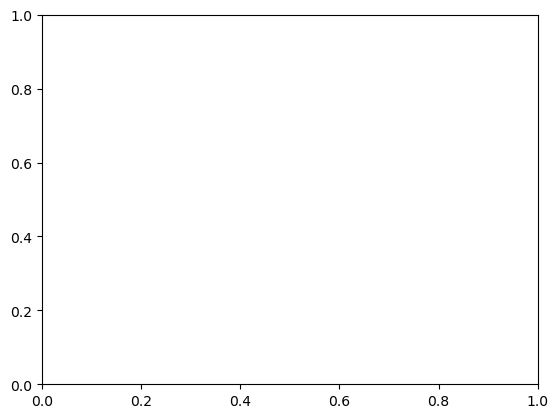

In [184]:
plt.plot(global_data[:])

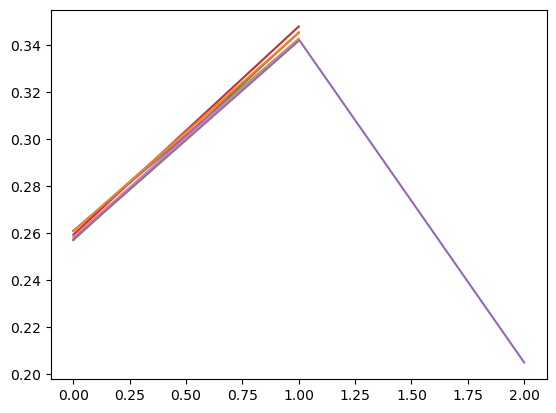

In [185]:
plt.plot(np.array(global_data[1][:]) )

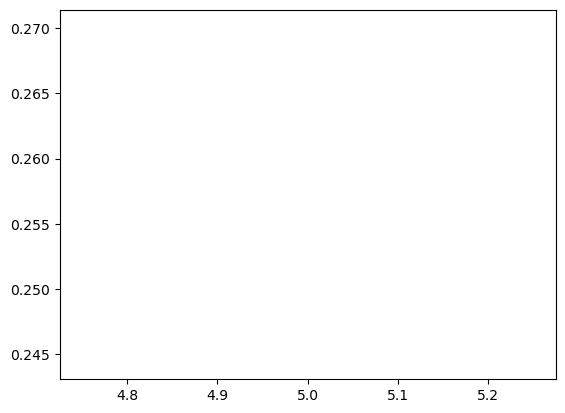

In [186]:
plt.plot(dynamics[0])

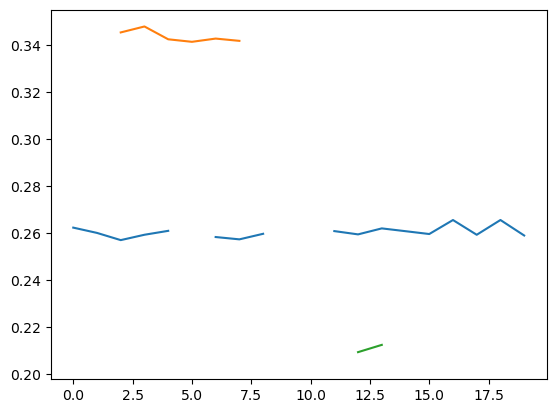

In [187]:
plt.plot(np.array(global_data[1]).T)

In [18]:
def edges_to_nx(edges: List[Edge], at_rho: float) -> nx.Graph:
    """
    Converts list of edges to networkx format
    :param edges: List[Edge]: list of edges that are used
    :param: at_rho: float: rho lower bound for filtering
    :return: None
    """
    G = nx.Graph()
    for edge in edges:
        if edge.rho < at_rho:
            continue
        G.add_edge(edge.src, edge.dst, rho=edge.rho)
    return G

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/557 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/306362 [00:00<?, ?it/s]

There's 3361 edges
There is 554 nodes in graph


  0%|          | 0/557 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/306362 [00:00<?, ?it/s]

There's 2283 edges
There is 554 nodes in graph


  0%|          | 0/557 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/306362 [00:00<?, ?it/s]

There's 2133 edges
There is 554 nodes in graph


  0%|          | 0/557 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/306362 [00:00<?, ?it/s]

There's 3205 edges
There is 554 nodes in graph


  0%|          | 0/557 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/306362 [00:00<?, ?it/s]

There's 2270 edges
There is 554 nodes in graph


  0%|          | 0/557 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/306362 [00:00<?, ?it/s]

There's 3272 edges
There is 554 nodes in graph


  0%|          | 0/557 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/306362 [00:00<?, ?it/s]

There's 2128 edges
There is 554 nodes in graph


  0%|          | 0/557 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/306362 [00:00<?, ?it/s]

There's 1930 edges
There is 554 nodes in graph


  0%|          | 0/557 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/306362 [00:00<?, ?it/s]

There's 2202 edges
There is 554 nodes in graph


  0%|          | 0/557 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/306362 [00:00<?, ?it/s]

There's 2212 edges
There is 554 nodes in graph


  0%|          | 0/557 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/306362 [00:00<?, ?it/s]

There's 2362 edges
There is 554 nodes in graph


  0%|          | 0/557 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/306362 [00:00<?, ?it/s]

There's 2000 edges
There is 554 nodes in graph


  0%|          | 0/557 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/306362 [00:00<?, ?it/s]

There's 1864 edges
There is 554 nodes in graph


  0%|          | 0/557 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/306362 [00:00<?, ?it/s]

There's 3798 edges
There is 554 nodes in graph


  0%|          | 0/557 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/306362 [00:00<?, ?it/s]

There's 2532 edges
There is 554 nodes in graph


  0%|          | 0/557 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/306362 [00:00<?, ?it/s]

There's 1747 edges
There is 554 nodes in graph


  0%|          | 0/557 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/306362 [00:00<?, ?it/s]

There's 1997 edges
There is 554 nodes in graph


  0%|          | 0/557 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/306362 [00:00<?, ?it/s]

There's 2130 edges
There is 554 nodes in graph


  0%|          | 0/557 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/306362 [00:00<?, ?it/s]

There's 2832 edges
There is 554 nodes in graph


  0%|          | 0/557 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/306362 [00:00<?, ?it/s]

There's 1816 edges
There is 554 nodes in graph
doing dynamics
still alive


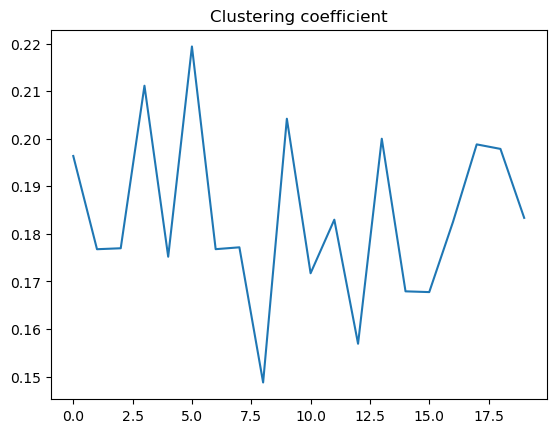

  0%|          | 0/478 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/225150 [00:00<?, ?it/s]

There's 81225 edges
There is 475 nodes in graph


  0%|          | 0/478 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/225150 [00:00<?, ?it/s]

There's 95555 edges
There is 475 nodes in graph


  0%|          | 0/478 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/225150 [00:00<?, ?it/s]

There's 118725 edges
There is 475 nodes in graph


  0%|          | 0/478 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/225150 [00:00<?, ?it/s]

There's 98000 edges
There is 475 nodes in graph


  0%|          | 0/478 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/225150 [00:00<?, ?it/s]

There's 68704 edges
There is 475 nodes in graph


  0%|          | 0/478 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/225150 [00:00<?, ?it/s]

There's 69549 edges
There is 475 nodes in graph


  0%|          | 0/478 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/225150 [00:00<?, ?it/s]

There's 66818 edges
There is 475 nodes in graph


  0%|          | 0/478 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/225150 [00:00<?, ?it/s]

There's 67374 edges
There is 475 nodes in graph


  0%|          | 0/478 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/225150 [00:00<?, ?it/s]

There's 69155 edges
There is 475 nodes in graph


  0%|          | 0/478 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/225150 [00:00<?, ?it/s]

There's 80892 edges
There is 475 nodes in graph


  0%|          | 0/478 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/225150 [00:00<?, ?it/s]

There's 70076 edges
There is 475 nodes in graph


  0%|          | 0/478 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/225150 [00:00<?, ?it/s]

There's 66234 edges
There is 475 nodes in graph


  0%|          | 0/478 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/225150 [00:00<?, ?it/s]

There's 69204 edges
There is 475 nodes in graph


  0%|          | 0/478 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/225150 [00:00<?, ?it/s]

There's 69878 edges
There is 475 nodes in graph


  0%|          | 0/478 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/225150 [00:00<?, ?it/s]

There's 70278 edges
There is 475 nodes in graph


  0%|          | 0/478 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/225150 [00:00<?, ?it/s]

There's 82039 edges
There is 475 nodes in graph


  0%|          | 0/478 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/225150 [00:00<?, ?it/s]

There's 74711 edges
There is 475 nodes in graph


  0%|          | 0/478 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/225150 [00:00<?, ?it/s]

There's 65855 edges
There is 475 nodes in graph


  0%|          | 0/478 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/225150 [00:00<?, ?it/s]

There's 66785 edges
There is 475 nodes in graph


  0%|          | 0/478 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/225150 [00:00<?, ?it/s]

There's 64828 edges
There is 475 nodes in graph
doing dynamics
still alive


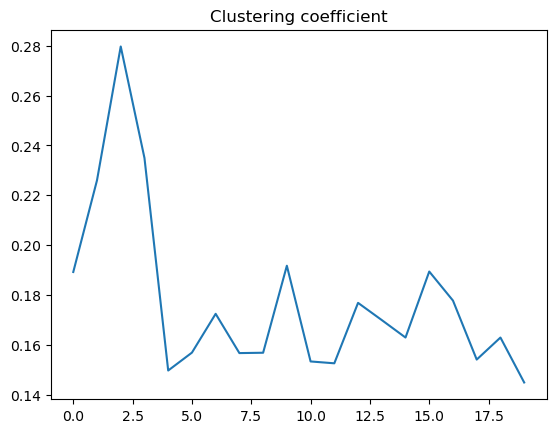

  0%|          | 0/523 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/269880 [00:00<?, ?it/s]

There's 1996 edges
There is 520 nodes in graph


  0%|          | 0/523 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/269880 [00:00<?, ?it/s]

There's 1544 edges
There is 520 nodes in graph


  0%|          | 0/523 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/269880 [00:00<?, ?it/s]

There's 2130 edges
There is 520 nodes in graph


  0%|          | 0/523 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/269880 [00:00<?, ?it/s]

There's 2118 edges
There is 520 nodes in graph


  0%|          | 0/523 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/269880 [00:00<?, ?it/s]

There's 1902 edges
There is 520 nodes in graph


  0%|          | 0/523 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/269880 [00:00<?, ?it/s]

There's 2225 edges
There is 520 nodes in graph


  0%|          | 0/523 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/269880 [00:00<?, ?it/s]

There's 2892 edges
There is 520 nodes in graph


  0%|          | 0/523 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/269880 [00:00<?, ?it/s]

There's 3831 edges
There is 520 nodes in graph


  0%|          | 0/523 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/269880 [00:00<?, ?it/s]

There's 1503 edges
There is 520 nodes in graph


  0%|          | 0/523 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/269880 [00:00<?, ?it/s]

There's 1867 edges
There is 520 nodes in graph


  0%|          | 0/523 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/269880 [00:00<?, ?it/s]

There's 1728 edges
There is 520 nodes in graph


  0%|          | 0/523 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/269880 [00:00<?, ?it/s]

There's 1514 edges
There is 520 nodes in graph


  0%|          | 0/523 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/269880 [00:00<?, ?it/s]

There's 2312 edges
There is 520 nodes in graph


  0%|          | 0/523 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/269880 [00:00<?, ?it/s]

There's 1996 edges
There is 520 nodes in graph


  0%|          | 0/523 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/269880 [00:00<?, ?it/s]

There's 1460 edges
There is 520 nodes in graph


  0%|          | 0/523 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/269880 [00:00<?, ?it/s]

There's 2228 edges
There is 520 nodes in graph


  0%|          | 0/523 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/269880 [00:00<?, ?it/s]

There's 3030 edges
There is 520 nodes in graph


  0%|          | 0/523 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/269880 [00:00<?, ?it/s]

There's 2052 edges
There is 520 nodes in graph


  0%|          | 0/523 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/269880 [00:00<?, ?it/s]

There's 1947 edges
There is 520 nodes in graph


  0%|          | 0/523 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/269880 [00:00<?, ?it/s]

There's 2083 edges
There is 520 nodes in graph
doing dynamics
still alive


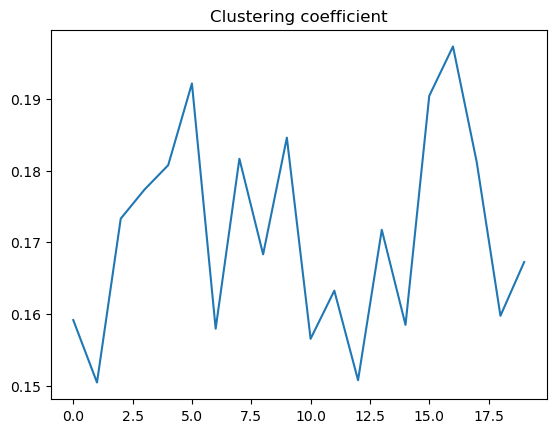

  0%|          | 0/233 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/52670 [00:00<?, ?it/s]

There's 1266 edges
There is 230 nodes in graph


  0%|          | 0/233 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/52670 [00:00<?, ?it/s]

There's 1618 edges
There is 230 nodes in graph


  0%|          | 0/233 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/52670 [00:00<?, ?it/s]

There's 1355 edges
There is 230 nodes in graph


  0%|          | 0/233 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/52670 [00:00<?, ?it/s]

There's 4139 edges
There is 230 nodes in graph


  0%|          | 0/233 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/52670 [00:00<?, ?it/s]

There's 1408 edges
There is 230 nodes in graph


  0%|          | 0/233 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/52670 [00:00<?, ?it/s]

There's 876 edges
There is 230 nodes in graph


  0%|          | 0/233 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/52670 [00:00<?, ?it/s]

There's 1379 edges
There is 230 nodes in graph


  0%|          | 0/233 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/52670 [00:00<?, ?it/s]

There's 1444 edges
There is 230 nodes in graph


  0%|          | 0/233 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/52670 [00:00<?, ?it/s]

There's 1949 edges
There is 230 nodes in graph


  0%|          | 0/233 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/52670 [00:00<?, ?it/s]

There's 1648 edges
There is 230 nodes in graph


  0%|          | 0/233 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/52670 [00:00<?, ?it/s]

There's 6152 edges
There is 230 nodes in graph


  0%|          | 0/233 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/52670 [00:00<?, ?it/s]

There's 1599 edges
There is 230 nodes in graph


  0%|          | 0/233 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/52670 [00:00<?, ?it/s]

There's 1210 edges
There is 230 nodes in graph


  0%|          | 0/233 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/52670 [00:00<?, ?it/s]

There's 1200 edges
There is 230 nodes in graph


  0%|          | 0/233 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/52670 [00:00<?, ?it/s]

There's 1249 edges
There is 230 nodes in graph


  0%|          | 0/233 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/52670 [00:00<?, ?it/s]

There's 2234 edges
There is 230 nodes in graph


  0%|          | 0/233 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/52670 [00:00<?, ?it/s]

There's 1042 edges
There is 230 nodes in graph


  0%|          | 0/233 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/52670 [00:00<?, ?it/s]

There's 1449 edges
There is 230 nodes in graph


  0%|          | 0/233 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/52670 [00:00<?, ?it/s]

There's 1063 edges
There is 230 nodes in graph


  0%|          | 0/233 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/52670 [00:00<?, ?it/s]

There's 989 edges
There is 230 nodes in graph
doing dynamics
still alive


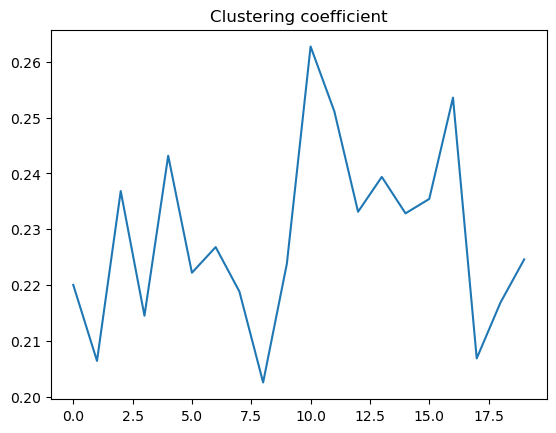

  0%|          | 0/198 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/37830 [00:00<?, ?it/s]

There's 12252 edges
There is 195 nodes in graph


  0%|          | 0/198 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/37830 [00:00<?, ?it/s]

There's 14253 edges
There is 195 nodes in graph


  0%|          | 0/198 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/37830 [00:00<?, ?it/s]

There's 15955 edges
There is 195 nodes in graph


  0%|          | 0/198 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/37830 [00:00<?, ?it/s]

There's 13599 edges
There is 195 nodes in graph


  0%|          | 0/198 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/37830 [00:00<?, ?it/s]

There's 17195 edges
There is 195 nodes in graph


  0%|          | 0/198 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/37830 [00:00<?, ?it/s]

There's 13872 edges
There is 195 nodes in graph


  0%|          | 0/198 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/37830 [00:00<?, ?it/s]

There's 12212 edges
There is 195 nodes in graph


  0%|          | 0/198 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/37830 [00:00<?, ?it/s]

There's 16940 edges
There is 195 nodes in graph


  0%|          | 0/198 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/37830 [00:00<?, ?it/s]

There's 14339 edges
There is 195 nodes in graph


  0%|          | 0/198 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/37830 [00:00<?, ?it/s]

There's 14834 edges
There is 195 nodes in graph


  0%|          | 0/198 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/37830 [00:00<?, ?it/s]

There's 19026 edges
There is 195 nodes in graph


  0%|          | 0/198 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/37830 [00:00<?, ?it/s]

There's 15399 edges
There is 195 nodes in graph


  0%|          | 0/198 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/37830 [00:00<?, ?it/s]

There's 15136 edges
There is 195 nodes in graph


  0%|          | 0/198 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/37830 [00:00<?, ?it/s]

There's 12222 edges
There is 195 nodes in graph


  0%|          | 0/198 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/37830 [00:00<?, ?it/s]

There's 13997 edges
There is 195 nodes in graph


  0%|          | 0/198 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/37830 [00:00<?, ?it/s]

There's 13367 edges
There is 195 nodes in graph


  0%|          | 0/198 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/37830 [00:00<?, ?it/s]

There's 14368 edges
There is 195 nodes in graph


  0%|          | 0/198 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/37830 [00:00<?, ?it/s]

There's 15361 edges
There is 195 nodes in graph


  0%|          | 0/198 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/37830 [00:00<?, ?it/s]

There's 13797 edges
There is 195 nodes in graph


  0%|          | 0/198 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/37830 [00:00<?, ?it/s]

There's 14435 edges
There is 195 nodes in graph
doing dynamics
still alive


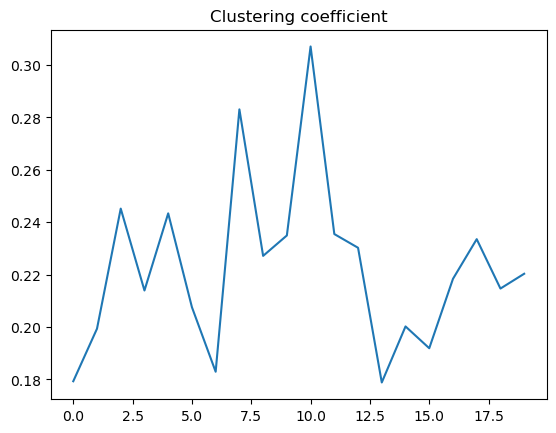

  0%|          | 0/72 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4692 [00:00<?, ?it/s]

There's 80 edges
There is 69 nodes in graph


  0%|          | 0/72 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4692 [00:00<?, ?it/s]

There's 88 edges
There is 69 nodes in graph


  0%|          | 0/72 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4692 [00:00<?, ?it/s]

There's 80 edges
There is 69 nodes in graph


  0%|          | 0/72 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4692 [00:00<?, ?it/s]

There's 82 edges
There is 69 nodes in graph


  0%|          | 0/72 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4692 [00:00<?, ?it/s]

There's 198 edges
There is 69 nodes in graph


  0%|          | 0/72 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4692 [00:00<?, ?it/s]

There's 58 edges
There is 69 nodes in graph


  0%|          | 0/72 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4692 [00:00<?, ?it/s]

There's 92 edges
There is 69 nodes in graph


  0%|          | 0/72 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4692 [00:00<?, ?it/s]

There's 80 edges
There is 69 nodes in graph


  0%|          | 0/72 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4692 [00:00<?, ?it/s]

There's 141 edges
There is 69 nodes in graph


  0%|          | 0/72 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4692 [00:00<?, ?it/s]

There's 80 edges
There is 69 nodes in graph


  0%|          | 0/72 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4692 [00:00<?, ?it/s]

There's 253 edges
There is 69 nodes in graph


  0%|          | 0/72 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4692 [00:00<?, ?it/s]

There's 74 edges
There is 69 nodes in graph


  0%|          | 0/72 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4692 [00:00<?, ?it/s]

There's 82 edges
There is 69 nodes in graph


  0%|          | 0/72 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4692 [00:00<?, ?it/s]

There's 100 edges
There is 69 nodes in graph


  0%|          | 0/72 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4692 [00:00<?, ?it/s]

There's 110 edges
There is 69 nodes in graph


  0%|          | 0/72 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4692 [00:00<?, ?it/s]

There's 102 edges
There is 69 nodes in graph


  0%|          | 0/72 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4692 [00:00<?, ?it/s]

There's 82 edges
There is 69 nodes in graph


  0%|          | 0/72 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4692 [00:00<?, ?it/s]

There's 138 edges
There is 69 nodes in graph


  0%|          | 0/72 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4692 [00:00<?, ?it/s]

There's 101 edges
There is 69 nodes in graph


  0%|          | 0/72 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4692 [00:00<?, ?it/s]

There's 74 edges
There is 69 nodes in graph
doing dynamics
still alive


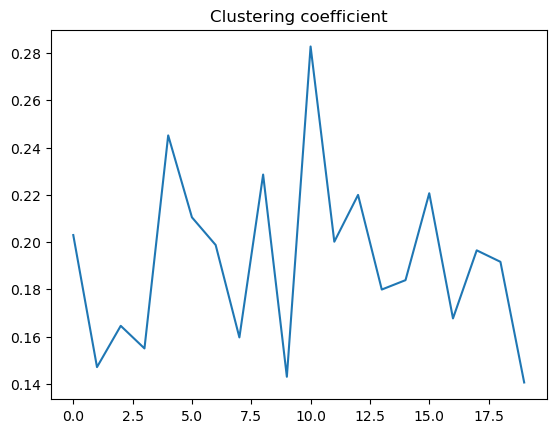

  0%|          | 0/68 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4160 [00:00<?, ?it/s]

There's 1571 edges
There is 65 nodes in graph


  0%|          | 0/68 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4160 [00:00<?, ?it/s]

There's 1367 edges
There is 65 nodes in graph


  0%|          | 0/68 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4160 [00:00<?, ?it/s]

There's 1397 edges
There is 65 nodes in graph


  0%|          | 0/68 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4160 [00:00<?, ?it/s]

There's 1266 edges
There is 65 nodes in graph


  0%|          | 0/68 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4160 [00:00<?, ?it/s]

There's 1458 edges
There is 65 nodes in graph


  0%|          | 0/68 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4160 [00:00<?, ?it/s]

There's 1334 edges
There is 65 nodes in graph


  0%|          | 0/68 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4160 [00:00<?, ?it/s]

There's 1297 edges
There is 65 nodes in graph


  0%|          | 0/68 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4160 [00:00<?, ?it/s]

There's 1427 edges
There is 65 nodes in graph


  0%|          | 0/68 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4160 [00:00<?, ?it/s]

There's 1598 edges
There is 65 nodes in graph


  0%|          | 0/68 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4160 [00:00<?, ?it/s]

There's 1278 edges
There is 65 nodes in graph


  0%|          | 0/68 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4160 [00:00<?, ?it/s]

There's 1587 edges
There is 65 nodes in graph


  0%|          | 0/68 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4160 [00:00<?, ?it/s]

There's 1546 edges
There is 65 nodes in graph


  0%|          | 0/68 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4160 [00:00<?, ?it/s]

There's 1380 edges
There is 65 nodes in graph


  0%|          | 0/68 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4160 [00:00<?, ?it/s]

There's 1438 edges
There is 65 nodes in graph


  0%|          | 0/68 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4160 [00:00<?, ?it/s]

There's 1332 edges
There is 65 nodes in graph


  0%|          | 0/68 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4160 [00:00<?, ?it/s]

There's 1534 edges
There is 65 nodes in graph


  0%|          | 0/68 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4160 [00:00<?, ?it/s]

There's 1439 edges
There is 65 nodes in graph


  0%|          | 0/68 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4160 [00:00<?, ?it/s]

There's 1385 edges
There is 65 nodes in graph


  0%|          | 0/68 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4160 [00:00<?, ?it/s]

There's 1266 edges
There is 65 nodes in graph


  0%|          | 0/68 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/4160 [00:00<?, ?it/s]

There's 1107 edges
There is 65 nodes in graph
doing dynamics
still alive


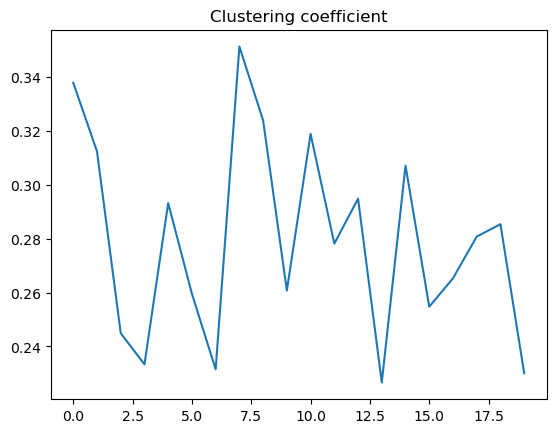

  0%|          | 0/77 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/5402 [00:00<?, ?it/s]

There's 2417 edges
There is 74 nodes in graph


  0%|          | 0/77 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/5402 [00:00<?, ?it/s]

There's 2387 edges
There is 74 nodes in graph


  0%|          | 0/77 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/5402 [00:00<?, ?it/s]

There's 1859 edges
There is 74 nodes in graph


  0%|          | 0/77 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/5402 [00:00<?, ?it/s]

There's 1721 edges
There is 74 nodes in graph


  0%|          | 0/77 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/5402 [00:00<?, ?it/s]

There's 1757 edges
There is 74 nodes in graph


  0%|          | 0/77 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/5402 [00:00<?, ?it/s]

There's 1969 edges
There is 74 nodes in graph


  0%|          | 0/77 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/5402 [00:00<?, ?it/s]

There's 1950 edges
There is 74 nodes in graph


  0%|          | 0/77 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/5402 [00:00<?, ?it/s]

There's 1510 edges
There is 74 nodes in graph


  0%|          | 0/77 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/5402 [00:00<?, ?it/s]

There's 1709 edges
There is 74 nodes in graph


  0%|          | 0/77 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/5402 [00:00<?, ?it/s]

There's 1993 edges
There is 74 nodes in graph


  0%|          | 0/77 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/5402 [00:00<?, ?it/s]

There's 1536 edges
There is 74 nodes in graph


  0%|          | 0/77 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/5402 [00:00<?, ?it/s]

There's 1832 edges
There is 74 nodes in graph


  0%|          | 0/77 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/5402 [00:00<?, ?it/s]

There's 1562 edges
There is 74 nodes in graph


  0%|          | 0/77 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/5402 [00:00<?, ?it/s]

There's 2008 edges
There is 74 nodes in graph


  0%|          | 0/77 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/5402 [00:00<?, ?it/s]

There's 1724 edges
There is 74 nodes in graph


  0%|          | 0/77 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/5402 [00:00<?, ?it/s]

There's 1637 edges
There is 74 nodes in graph


  0%|          | 0/77 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/5402 [00:00<?, ?it/s]

There's 1559 edges
There is 74 nodes in graph


  0%|          | 0/77 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/5402 [00:00<?, ?it/s]

There's 1660 edges
There is 74 nodes in graph


  0%|          | 0/77 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/5402 [00:00<?, ?it/s]

There's 1713 edges
There is 74 nodes in graph


  0%|          | 0/77 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/5402 [00:00<?, ?it/s]

There's 1607 edges
There is 74 nodes in graph
doing dynamics
still alive


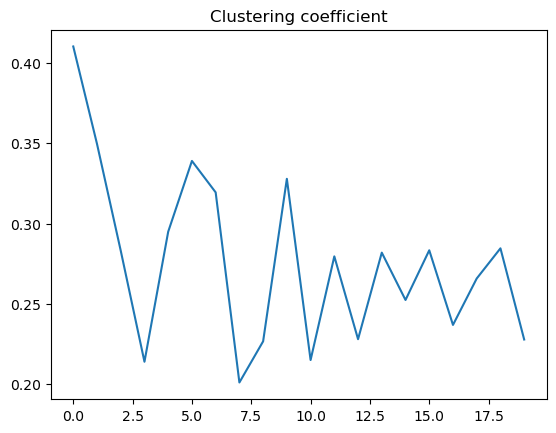

  0%|          | 0/48 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/1980 [00:00<?, ?it/s]

There's 18 edges
There is 45 nodes in graph


  0%|          | 0/48 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/1980 [00:00<?, ?it/s]

There's 22 edges
There is 45 nodes in graph


  0%|          | 0/48 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/1980 [00:00<?, ?it/s]

There's 31 edges
There is 45 nodes in graph


  0%|          | 0/48 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/1980 [00:00<?, ?it/s]

There's 14 edges
There is 45 nodes in graph


  0%|          | 0/48 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/1980 [00:00<?, ?it/s]

There's 14 edges
There is 45 nodes in graph


  0%|          | 0/48 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/1980 [00:00<?, ?it/s]

There's 22 edges
There is 45 nodes in graph


  0%|          | 0/48 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/1980 [00:00<?, ?it/s]

There's 16 edges
There is 45 nodes in graph


  0%|          | 0/48 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/1980 [00:00<?, ?it/s]

There's 12 edges
There is 45 nodes in graph


  0%|          | 0/48 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/1980 [00:00<?, ?it/s]

There's 10 edges
There is 45 nodes in graph


  0%|          | 0/48 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/1980 [00:00<?, ?it/s]

There's 28 edges
There is 45 nodes in graph


  0%|          | 0/48 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/1980 [00:00<?, ?it/s]

There's 17 edges
There is 45 nodes in graph


  0%|          | 0/48 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/1980 [00:00<?, ?it/s]

There's 12 edges
There is 45 nodes in graph


  0%|          | 0/48 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/1980 [00:00<?, ?it/s]

There's 6 edges
There is 45 nodes in graph


  0%|          | 0/48 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/1980 [00:00<?, ?it/s]

There's 18 edges
There is 45 nodes in graph


  0%|          | 0/48 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/1980 [00:00<?, ?it/s]

There's 18 edges
There is 45 nodes in graph


  0%|          | 0/48 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/1980 [00:00<?, ?it/s]

There's 8 edges
There is 45 nodes in graph


  0%|          | 0/48 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/1980 [00:00<?, ?it/s]

There's 16 edges
There is 45 nodes in graph


  0%|          | 0/48 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/1980 [00:00<?, ?it/s]

There's 8 edges
There is 45 nodes in graph


  0%|          | 0/48 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/1980 [00:00<?, ?it/s]

There's 24 edges
There is 45 nodes in graph


  0%|          | 0/48 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/1980 [00:00<?, ?it/s]

There's 12 edges
There is 45 nodes in graph
doing dynamics
still alive


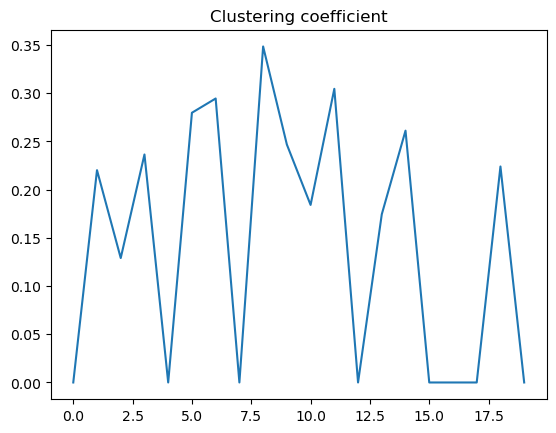

  0%|          | 0/297 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/86142 [00:00<?, ?it/s]

There's 1604 edges
There is 294 nodes in graph


  0%|          | 0/297 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/86142 [00:00<?, ?it/s]

There's 2282 edges
There is 294 nodes in graph


  0%|          | 0/297 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/86142 [00:00<?, ?it/s]

There's 1675 edges
There is 294 nodes in graph


  0%|          | 0/297 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/86142 [00:00<?, ?it/s]

There's 2158 edges
There is 294 nodes in graph


  0%|          | 0/297 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/86142 [00:00<?, ?it/s]

There's 1120 edges
There is 294 nodes in graph


  0%|          | 0/297 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/86142 [00:00<?, ?it/s]

There's 1141 edges
There is 294 nodes in graph


  0%|          | 0/297 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/86142 [00:00<?, ?it/s]

There's 1484 edges
There is 294 nodes in graph


  0%|          | 0/297 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/86142 [00:00<?, ?it/s]

There's 995 edges
There is 294 nodes in graph


  0%|          | 0/297 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/86142 [00:00<?, ?it/s]

There's 903 edges
There is 294 nodes in graph


  0%|          | 0/297 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/86142 [00:00<?, ?it/s]

There's 888 edges
There is 294 nodes in graph


  0%|          | 0/297 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/86142 [00:00<?, ?it/s]

There's 916 edges
There is 294 nodes in graph


  0%|          | 0/297 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/86142 [00:00<?, ?it/s]

There's 3738 edges
There is 294 nodes in graph


  0%|          | 0/297 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/86142 [00:00<?, ?it/s]

There's 2186 edges
There is 294 nodes in graph


  0%|          | 0/297 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/86142 [00:00<?, ?it/s]

There's 1130 edges
There is 294 nodes in graph


  0%|          | 0/297 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/86142 [00:00<?, ?it/s]

There's 1019 edges
There is 294 nodes in graph


  0%|          | 0/297 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/86142 [00:00<?, ?it/s]

There's 1294 edges
There is 294 nodes in graph


  0%|          | 0/297 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/86142 [00:00<?, ?it/s]

There's 1186 edges
There is 294 nodes in graph


  0%|          | 0/297 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/86142 [00:00<?, ?it/s]

There's 1320 edges
There is 294 nodes in graph


  0%|          | 0/297 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/86142 [00:00<?, ?it/s]

There's 1658 edges
There is 294 nodes in graph


  0%|          | 0/297 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/86142 [00:00<?, ?it/s]

There's 1039 edges
There is 294 nodes in graph
doing dynamics
still alive


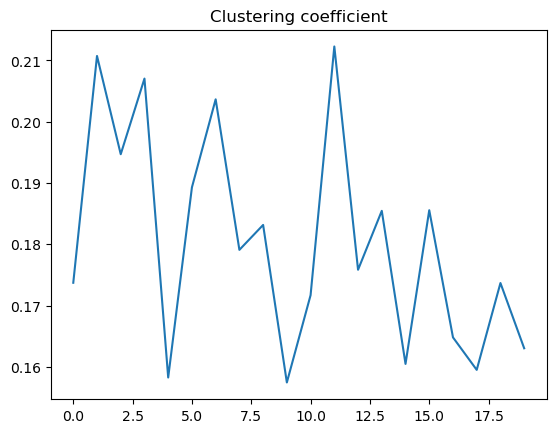

  0%|          | 0/558 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/307470 [00:00<?, ?it/s]

There's 99222 edges
There is 555 nodes in graph


  0%|          | 0/558 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/307470 [00:00<?, ?it/s]

There's 93558 edges
There is 555 nodes in graph


  0%|          | 0/558 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/307470 [00:00<?, ?it/s]

There's 111863 edges
There is 555 nodes in graph


  0%|          | 0/558 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/307470 [00:00<?, ?it/s]

There's 99152 edges
There is 555 nodes in graph


  0%|          | 0/558 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/307470 [00:00<?, ?it/s]

There's 112184 edges
There is 555 nodes in graph


  0%|          | 0/558 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/307470 [00:00<?, ?it/s]

There's 83721 edges
There is 555 nodes in graph


  0%|          | 0/558 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/307470 [00:00<?, ?it/s]

There's 112884 edges
There is 555 nodes in graph


  0%|          | 0/558 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/307470 [00:00<?, ?it/s]

There's 92258 edges
There is 555 nodes in graph


  0%|          | 0/558 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/307470 [00:00<?, ?it/s]

There's 103016 edges
There is 555 nodes in graph


  0%|          | 0/558 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/307470 [00:00<?, ?it/s]

There's 89246 edges
There is 555 nodes in graph


  0%|          | 0/558 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/307470 [00:00<?, ?it/s]

There's 93700 edges
There is 555 nodes in graph


  0%|          | 0/558 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/307470 [00:00<?, ?it/s]

There's 88762 edges
There is 555 nodes in graph


  0%|          | 0/558 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/307470 [00:00<?, ?it/s]

There's 114264 edges
There is 555 nodes in graph


  0%|          | 0/558 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/307470 [00:00<?, ?it/s]

There's 93582 edges
There is 555 nodes in graph


  0%|          | 0/558 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/307470 [00:00<?, ?it/s]

There's 95674 edges
There is 555 nodes in graph


  0%|          | 0/558 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/307470 [00:00<?, ?it/s]

There's 82125 edges
There is 555 nodes in graph


  0%|          | 0/558 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/307470 [00:00<?, ?it/s]

There's 109152 edges
There is 555 nodes in graph


  0%|          | 0/558 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/307470 [00:00<?, ?it/s]

There's 91018 edges
There is 555 nodes in graph


  0%|          | 0/558 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/307470 [00:00<?, ?it/s]

There's 101198 edges
There is 555 nodes in graph


  0%|          | 0/558 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/307470 [00:00<?, ?it/s]

There's 92647 edges
There is 555 nodes in graph
doing dynamics
still alive


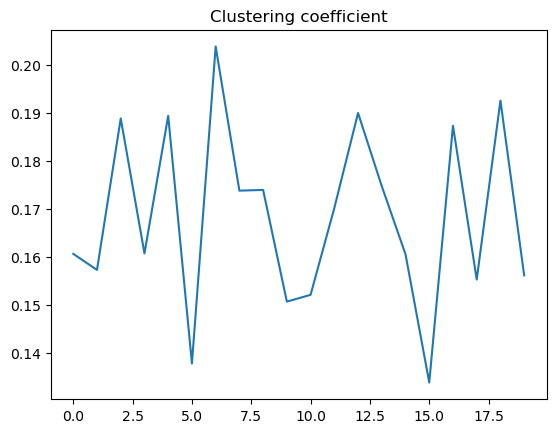

  0%|          | 0/478 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/225150 [00:00<?, ?it/s]

There's 74261 edges
There is 475 nodes in graph


  0%|          | 0/478 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/225150 [00:00<?, ?it/s]

There's 73644 edges
There is 475 nodes in graph


  0%|          | 0/478 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/225150 [00:00<?, ?it/s]

There's 90689 edges
There is 475 nodes in graph


  0%|          | 0/478 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/225150 [00:00<?, ?it/s]

There's 76713 edges
There is 475 nodes in graph


  0%|          | 0/478 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/225150 [00:00<?, ?it/s]

There's 68782 edges
There is 475 nodes in graph


  0%|          | 0/478 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/225150 [00:00<?, ?it/s]

There's 103142 edges
There is 475 nodes in graph


  0%|          | 0/478 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/225150 [00:00<?, ?it/s]

There's 68108 edges
There is 475 nodes in graph


  0%|          | 0/478 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/225150 [00:00<?, ?it/s]

There's 80153 edges
There is 475 nodes in graph


  0%|          | 0/478 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/225150 [00:00<?, ?it/s]

There's 68013 edges
There is 475 nodes in graph


  0%|          | 0/478 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/225150 [00:00<?, ?it/s]

There's 70302 edges
There is 475 nodes in graph


  0%|          | 0/478 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/225150 [00:00<?, ?it/s]

There's 66708 edges
There is 475 nodes in graph


  0%|          | 0/478 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/225150 [00:00<?, ?it/s]

There's 77422 edges
There is 475 nodes in graph


  0%|          | 0/478 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/225150 [00:00<?, ?it/s]

There's 70431 edges
There is 475 nodes in graph


  0%|          | 0/478 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/225150 [00:00<?, ?it/s]

There's 72116 edges
There is 475 nodes in graph


  0%|          | 0/478 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/225150 [00:00<?, ?it/s]

There's 70182 edges
There is 475 nodes in graph


  0%|          | 0/478 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/225150 [00:00<?, ?it/s]

There's 66223 edges
There is 475 nodes in graph


  0%|          | 0/478 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/225150 [00:00<?, ?it/s]

There's 72044 edges
There is 475 nodes in graph


  0%|          | 0/478 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/225150 [00:00<?, ?it/s]

There's 67276 edges
There is 475 nodes in graph


  0%|          | 0/478 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/225150 [00:00<?, ?it/s]

There's 70783 edges
There is 475 nodes in graph


  0%|          | 0/478 [00:00<?, ?it/s]

NaNs detected in rho values, would not build plots


  0%|          | 0/225150 [00:00<?, ?it/s]

There's 68679 edges
There is 475 nodes in graph
doing dynamics
still alive


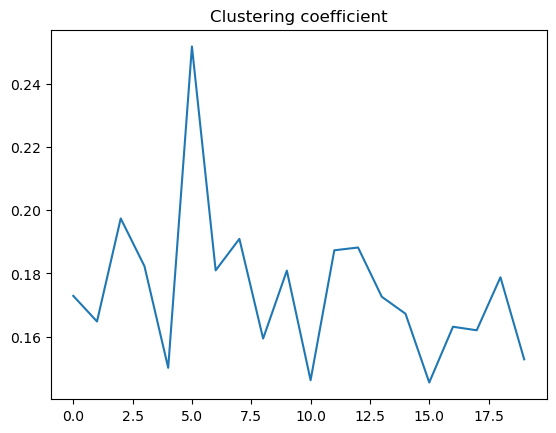

yes, still alive


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
from tqdm.notebook import tqdm


mice = [pd.read_csv("../../../data/22ht1.csv"), pd.read_csv("../../../data/22ht2.csv"), pd.read_csv("../../../data/22ht3.csv"),\
       pd.read_csv("../../../data/23ht1.csv"), pd.read_csv("../../../data/23ht2.csv"), pd.read_csv("../../../data/23ht3.csv"),\
       pd.read_csv("../../../data/24ht1.csv"), pd.read_csv("../../../data/24ht2.csv"), pd.read_csv("../../../data/24ht3.csv"),\
       pd.read_csv("../../../data/25ht1.csv"), pd.read_csv("../../../data/25ht2.csv"), pd.read_csv("../../../data/25ht3.csv")]
D = []
for i in range(len(mice)):
    D0 = mice[i].copy()
    if i == 0:
        D0 = D0.drop(["Unnamed: 0", "Unnamed: 0.2", "Unnamed: 0.1"], axis=1)
    else:
        D0 = D0.drop(["Unnamed: 0", "Unnamed: 0.1"], axis=1)
    D0 = D0.drop(["time_s"], axis=1)
    D0 = standardize_df(D0)
    D0 = D0.assign(time_s=mice[i].time_s)
    D.append(D0)

global_data = list()
global_graph_dyns = list()
dynamics = list()
adjacencies = list()
for i in tqdm(range(len(D))):
    
    graph_dyns = list()
    df_norm = pd.DataFrame(D[i])
    slices = get_slices(dataframe=df_norm, n=20)

    graphs, edge_lists = list(), list()
    
    j = 0
    for slice in slices:
        if len(slice) < 100:
            print(f"WARNING: too small slice({len(slice)} entries), ignoring")
            continue
        graph, edges = build_graph(coh, dataframe=slice)
        plot_graph_pyvis(edges, 0.36, name="coh_graph_slice_%d" % j % i)
        graphs.append(graph)
        edge_lists.append(edges)
        j += 1
    print('doing dynamics')
    global_graph_dyns.append(graph_dyns)
    dynamics_tmp = list()
    for edges in edge_lists:
        if len(edges) < 500:
            continue
        avg = sum([edge.rho for edge in edges])
        avg /= len(edges)
        dynamics_tmp.append(avg)
        #sns.plot(dynamics_tmp)
        #plt.show()
    plt.title("Dynamics of $\\bar\\rho$ over slices")
    #plt.plot(dynamics)
    #plt.show()
    #plt.imsave('dynamics'+i+'.png')
    dynamics.append(dynamics_tmp.copy())
    print('still alive')
    
    clusterization = list()
    avg = lambda a: sum(a) / len(a)
    for edges in edge_lists:
        clusterization.append(avg(nx.clustering(edges_to_nx(edges, 0.36), weight='rho').values()))
    plt.title("Clustering coefficient")
    plt.plot(clusterization)
    plt.show()
    global_data.append(clusterization.copy())
print('yes, still alive')
#plt.title("Dynamics of $\\bar\\rho$ over slices")
#sns.plot(np.array(dynamics).T[:])
#plt.show()
#plt.imsave('mouse'+i+'.png')
    


ValueError: x and y can be no greater than 2D, but have shapes (4,) and (4, 3, 20)

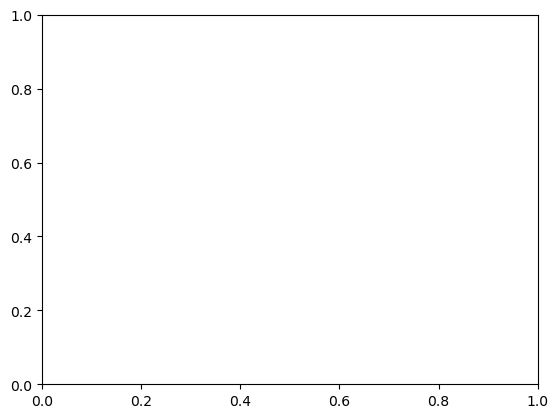

In [4]:
plt.plot(global_data[:])



In [5]:
for i in range(3):
    (plt.plot(global_data[i+9]))

IndexError: list index out of range

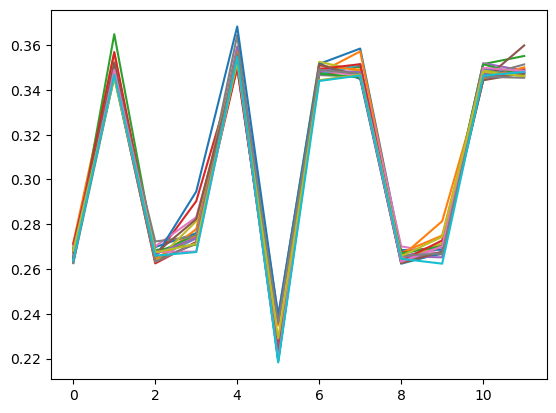

In [22]:
plt.plot(dynamics[:])

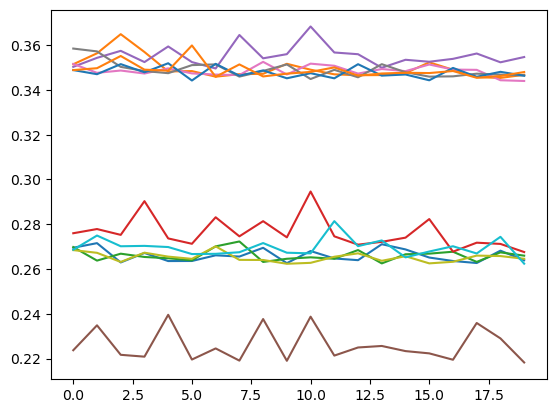

In [23]:
for i in range(len(dynamics)):
    plt.plot(dynamics[i])

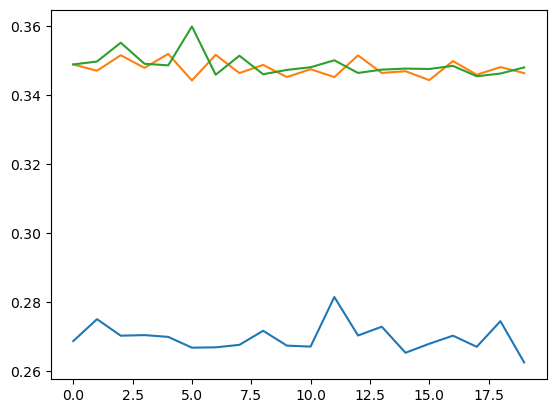

In [24]:
for i in range(3):
    plt.plot(dynamics[i+9])

In [25]:
ticks = np.array(['Mouse 1','Mouse 1','Mouse 1','Mouse 2','Mouse 2','Mouse 2', 'Mouse 3','Mouse 3','Mouse 3',
                 'Mouse 4', 'Mouse 4','Mouse 4'])


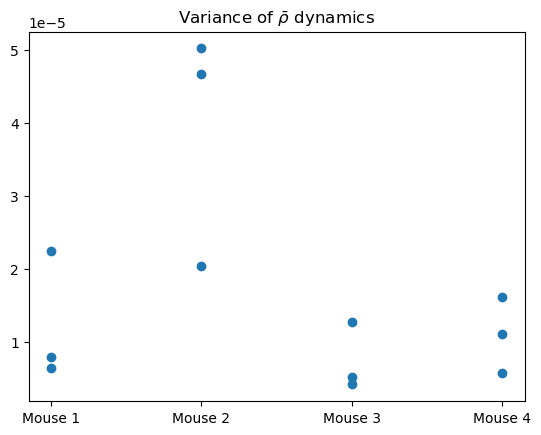

In [26]:
std = []
for i in range(len(dynamics)):
    std.append(np.var(dynamics[i]))
    
    
fig, ax = plt.subplots()
fig.canvas.draw()
plt.title("Variance of $\\bar\\rho$ dynamics")

#plt.locator_params(axis='x', nbins=4)
#labels = [item.get_text() for item in ax.get_xticklabels()]
#labels[1] = 'Mouse 1'
#labels[2] = 'Mouse 2'
#labels[3] = 'Mouse 3'
#labels[4] = 'Mouse 4'    
    
plt.scatter(ticks, std)
plt.savefig('Variance_rho.png')

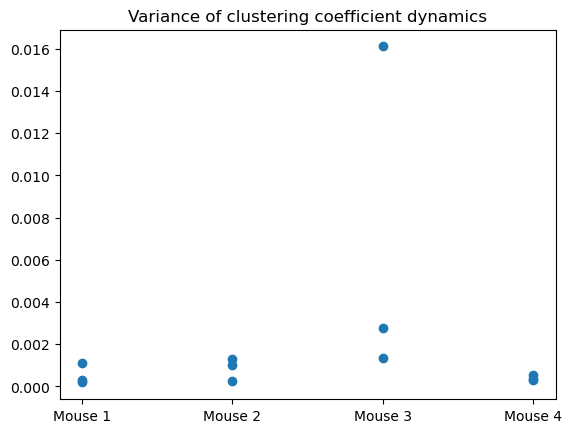

In [27]:
std_cl = []
for i in range(len(global_data)):
    std_cl.append(np.var(global_data[i]))
    
fig, ax = plt.subplots()
fig.canvas.draw()
plt.title("Variance of clustering coefficient dynamics")


#plt.locator_params(axis='x', nbins=4)
#labels = [item.get_text() for item in ax.get_xticklabels()]
#labels[1] = 'Mouse 1'
#abels[2] = 'Mouse 2'
#labels[3] = 'Mouse 3'
#labels[4] = 'Mouse 4'

#ax.set_xticklabels(labels)

plt.scatter(ticks, np.array(std_cl))
plt.savefig('Variance_cl.png')

In [28]:
std

[7.975459734963105e-06,
 2.244099781825783e-05,
 6.399881941450249e-06,
 4.6700955199358226e-05,
 2.0419069111285846e-05,
 5.0175295702202714e-05,
 5.185651402106086e-06,
 1.2738574489531097e-05,
 4.163590362966872e-06,
 1.607529410414096e-05,
 5.781417327491479e-06,
 1.1056955014338234e-05]

In [29]:
std_cl

[0.0003073332365526506,
 0.001095859901089314,
 0.00018842466409801613,
 0.0002504262708427073,
 0.0009993002517198128,
 0.0012821645055952672,
 0.0013383843238341585,
 0.0027500938456890573,
 0.0161099588039377,
 0.000305386537495691,
 0.0003479223212863635,
 0.0005338247444697261]

In [30]:
import sagemath

ModuleNotFoundError: No module named 'sagemath'

In [ ]:
sagemath.graphs

In [ ]:
Integer

# Calculcate metrics

## Hyperbolicity

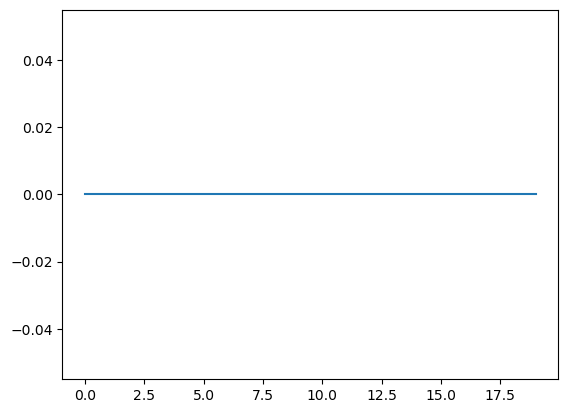

In [34]:
from sage.graphs.hyperbolicity import hyperbolicity, hyperbolicity_distribution
from sage.graphs.graph import Graph
from sage.matrix.constructor import matrix

#if HAS_SAGE:
def graph_from_edges(edges: List[Edge]) -> Graph:
    graph = Graph()
    vertices = set()
    for edge in edges:
        if edge.src not in vertices:
            graph.add_vertex(edge.src)
            vertices.add(edge.src)
        if edge.dst not in vertices:
            graph.add_vertex(edge.src)
            vertices.add(edge.dst)
        graph.add_edge(edge.src, edge.dst)
    return graph

#if HAS_SAGE:
i = 0
hs = list()
for edges in edge_lists:
    i += 1
    h = hyperbolicity(graph_from_edges(edges))
    hs.append(h[0])
    
    
#if HAS_SAGE:
plt.plot(hs)
plt.show()



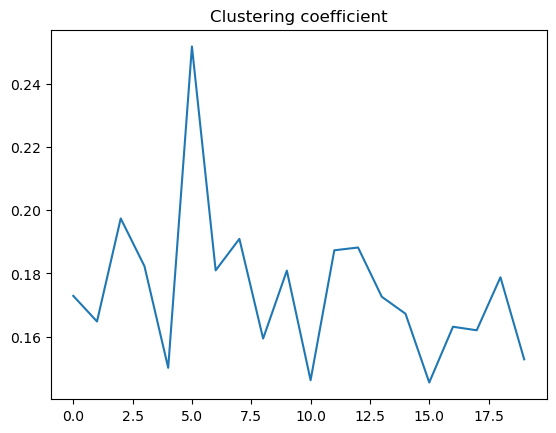

In [35]:
def edges_to_nx(edges: List[Edge], at_rho: float) -> nx.Graph:
    """
    Converts list of edges to networkx format
    :param edges: List[Edge]: list of edges that are used
    :param: at_rho: float: rho lower bound for filtering
    :return: None
    """
    G = nx.Graph()
    for edge in edges:
        if edge.rho < at_rho:
            continue
        G.add_edge(edge.src, edge.dst, rho=edge.rho)
    return G

clusterization = list()
avg = lambda a: sum(a) / len(a)
for edges in edge_lists:
    clusterization.append(avg(nx.clustering(edges_to_nx(edges, 0.36), weight='rho').values()))
    
plt.title("Clustering coefficient")
plt.plot(clusterization)
plt.show()



In [36]:
def plot_igraph_to_file(edges: List[Edge], fname: str, rho_min: float=0.36):
    plt.rcParams["figure.figsize"] = (20, 20,)
    g = ig.Graph()
    vetrices = set()
    for edge in tqdm(edges):
        if edge.rho < rho_min:
            continue
        if edge.dst not in vetrices:
            g.add_vertex(edge.dst)
        if edge.src not in vetrices:
            g.add_vertex(edge.src)
        vetrices.add(edge.src)
        vetrices.add(edge.dst)
        g[edge.src, edge.dst] = edge.rho
    #plt.title(fname)
    ig.plot(g)
    plt.savefig(fname + ".png")

In [1]:
def is_hyperbolic(distance_matrix, delta):
    n = distance_matrix.shape[Integer(0)]
    for i in tqdm(range(n)):
        for j in tqdm(range(i+Integer(1), n)):
            for k in range(j+Integer(1), n):
                d_ij = distance_matrix[i,j]
                d_ik = distance_matrix[i,k]
                d_jk = distance_matrix[j,k]
                if d_ij <= max(d_ik, d_jk) + delta and \
                   d_ik <= max(d_ij, d_jk) + delta and \
                   d_jk <= max(d_ij, d_ik) + delta:
                    continue
                else:
                    return False
    return True